# Molecular chemistry with NN( Keras Multiple Output)

I'm not a domain expert in the molecular chemistry. To learn a bit more in this fild this  notebook with input data from the kaggle competition  [https://www.kaggle.com/c/champs-scalar-coupling]
Initial approach and structure of NN is based on https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/ and https://www.kaggle.com/kmat2019/neural-network-modeling-with-multiple-outputs . Step by step some compatibility(Tensorflow 2.x and 1.x) and other  issues were solved.

Task here is predicting the scalar_coupling_constant between atom pairs in molecules, given the two atom types (e.g., C and H), the coupling type (e.g., 2JHC), and any features you are able to create from the molecule structure (xyz) files.

There is need to predict the pairs that are explicitly listed in the train and test files. For example, some molecules contain Fluorine (F), there is no need to  predict the scalar coupling constant for any pair that includes F.

The training and test splits are by molecule, so that no molecule in the training data is found in the test data.

# 1. Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from datetime import datetime
from tqdm import tqdm

# %tensorflow_version 1.x
 # if you want newest  2.x  delete this line
# generally if you put this line somewher in the middle of the notebook there is need to restart the runtime
import tensorflow as tf
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K 
from keras.layers.advanced_activations import LeakyReLU
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import os
# %cd /kaggle/input/champs-scalar-coupling
# print(os.listdir("."))

# Any results you write to the current directory are saved as output.
print('Tensorflow  v', tf.__version__)

Tensorflow  v 2.4.1


In [2]:
import keras
print(keras.__version__)

2.4.3


## Mount google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load standard snipet to prevent random disconnects

This cell runs JS code to automatic reconnect to runtime.

In [4]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


## Check GPU

*   Google Colab can provide you with one of Tesla graphics cards: K80, T4, P4 or P100
*   Here you can check the model of GPU before using some advanced features

In [5]:
!nvidia-smi

Sat Mar  6 14:18:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2. First grab the data.( here from google drive). 


In [6]:
print(os.listdir("/content/drive/MyDrive/mole"))

['keras-neural-net-for-champs.ipynb', 'neural-network-modeling-with-multiple-outputs.ipynb', 'useful.df_funcions.py', 'mole.zip', 'structures.csv', 'magnetic_shielding_tensors.csv', 'mulliken_charges.csv', 'train.csv', 'test.csv', 'neural_net', '.ipynb_checkpoints', 'neural_net_2x', 'neural_net_2xa', '09_keras-neural-net-for-champs.ipynb', 'notebooks', '10_keras-neural-net-for-champs.ipynb']


In [7]:
mydrive='/content/drive/MyDrive/mole'

In [8]:
df_train=pd.read_csv('{}/train.csv'.format(mydrive))
df_test=pd.read_csv('{}/test.csv'.format(mydrive))
df_struct=pd.read_csv('{}/structures.csv'.format(mydrive))

In [9]:
#df_train_sub_potential=pd.read_csv('/content/champs/potential_energy.csv')
#df_train_sub_moment=pd.read_csv('../input/dipole_moments.csv')
df_train_sub_charge=pd.read_csv('{}/mulliken_charges.csv'.format(mydrive))
df_train_sub_tensor=pd.read_csv('{}/magnetic_shielding_tensors.csv'.format(mydrive))


# 3. Reduce the Memory Usage( by ajusting data types)
Without this call, this kernel definitely can't be run on smaller cloud instances... I always test solutions on CoLaboratory to see if low-resource nodes can process them.  In this case, CoLab can't unless you reduce down.  The results seem similar to when the same network is trained on the full dataset.

In [10]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [11]:
print(df_train.shape, df_test.shape, df_struct.shape, df_train_sub_charge.shape, df_train_sub_tensor.shape)

(4659076, 6) (2505190, 5) (2358875, 6) (2358875, 3) (2358875, 11)


In [12]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_struct = reduce_mem_usage(df_struct)
df_train_sub_charge = reduce_mem_usage(df_train_sub_charge)
df_train_sub_tensor = reduce_mem_usage(df_train_sub_tensor)
print(df_train.shape, df_test.shape, df_struct.shape, df_train_sub_charge.shape, df_train_sub_tensor.shape)

Mem. usage decreased to 106.64 Mb (50.0% reduction)
Mem. usage decreased to 52.56 Mb (45.0% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to 24.75 Mb (54.2% reduction)
Mem. usage decreased to 60.74 Mb (69.3% reduction)
(4659076, 6) (2505190, 5) (2358875, 6) (2358875, 3) (2358875, 11)


In [13]:
df_train_sub_charge.sample(3)

,molecule_name,atom_index,mulliken_charge
520364,dsgdb9nsd_033152,12,0.113220
2316905,dsgdb9nsd_130535,11,0.140991
974039,dsgdb9nsd_059429,14,0.075134


# 3. Map data into a master dataframe
Here's the code to do mappings.  The drop_duplicates is important, else your test dataset will grow and your predictions will not be output correctly.

In [14]:
''' 
Map atom info from the structures.csv into the train/test files
'''
import psutil
import os

def map_atom_info(df_1,df_2, atom_idx):
    print('Mapping...', df_1.shape, df_2.shape, atom_idx)
    
    df = pd.merge(df_1, df_2.drop_duplicates(subset=['molecule_name', 'atom_index']), how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)

    return df

def show_ram_usage():
    py = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

show_ram_usage()

for atom_idx in [0,1]:
    df_train = map_atom_info(df_train,df_struct, atom_idx)
    df_train = map_atom_info(df_train,df_train_sub_charge, atom_idx)
    df_train = map_atom_info(df_train,df_train_sub_tensor, atom_idx)
    df_train = df_train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'mulliken_charge': f'charge_{atom_idx}',
                                        'XX': f'XX_{atom_idx}',
                                        'YX': f'YX_{atom_idx}',
                                        'ZX': f'ZX_{atom_idx}',
                                        'XY': f'XY_{atom_idx}',
                                        'YY': f'YY_{atom_idx}',
                                        'ZY': f'ZY_{atom_idx}',
                                        'XZ': f'XZ_{atom_idx}',
                                        'YZ': f'YZ_{atom_idx}',
                                        'ZZ': f'ZZ_{atom_idx}',})
    df_test = map_atom_info(df_test,df_struct, atom_idx)
    df_test = df_test.rename(columns={'atom': f'atom_{atom_idx}',
                                'x': f'x_{atom_idx}',
                                'y': f'y_{atom_idx}',
                                'z': f'z_{atom_idx}'})
    #add some features
    
    df_struct['c_x']=df_struct.groupby('molecule_name')['x'].transform('mean')
    df_struct['c_y']=df_struct.groupby('molecule_name')['y'].transform('mean')
    df_struct['c_z']=df_struct.groupby('molecule_name')['z'].transform('mean')
    df_struct['atom_n']=df_struct.groupby('molecule_name')['atom_index'].transform('max')
    
    show_ram_usage()
    print(df_train.shape, df_test.shape)

RAM usage: 1.2571334838867188 GB
Mapping... (4659076, 6) (2358875, 6) 0
Mapping... (4659076, 10) (2358875, 3) 0
Mapping... (4659076, 11) (2358875, 11) 0
Mapping... (2505190, 5) (2358875, 6) 0
RAM usage: 1.8457374572753906 GB
(4659076, 20) (2505190, 9)
Mapping... (4659076, 20) (2358875, 10) 1
Mapping... (4659076, 28) (2358875, 3) 1
Mapping... (4659076, 29) (2358875, 11) 1
Mapping... (2505190, 9) (2358875, 10) 1
RAM usage: 3.0559654235839844 GB
(4659076, 38) (2505190, 17)


In [15]:
 df_struct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358875 entries, 0 to 2358874
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   molecule_name  object 
 1   atom_index     int8   
 2   atom           object 
 3   x              float16
 4   y              float16
 5   z              float16
 6   c_x            float16
 7   c_y            float16
 8   c_z            float16
 9   atom_n         int8   
dtypes: float16(6), int8(2), object(2)
memory usage: 67.5+ MB


In [16]:
df_struct.sample(7)

,molecule_name,atom_index,atom,x,y,z,c_x,c_y,c_z,atom_n
1643541,dsgdb9nsd_094904,13,H,-4.292969,-0.632812,0.125977,-1.312500,0.033966,0.343262,17
2176788,dsgdb9nsd_121703,3,C,-1.381836,-1.682617,-1.248047,-2.113281,-1.311523,0.044586,18
160860,dsgdb9nsd_010493,6,C,-1.650391,-1.914062,0.299561,-1.271484,-0.143921,-0.133179,15
883030,dsgdb9nsd_054385,9,H,0.705566,1.927734,-0.097290,-0.036499,-1.206055,0.040253,17
1146241,dsgdb9nsd_068602,9,H,0.987793,1.926758,-0.100037,-0.531738,-0.369141,0.055023,19
1168668,dsgdb9nsd_069833,9,H,1.101562,1.839844,0.407471,-0.503418,-0.823730,0.420898,19
2138201,dsgdb9nsd_119843,12,H,0.145508,-0.550293,0.777344,0.639160,-1.468750,-1.134766,18


# 4. Start developing more complex features

In [17]:
def make_features(df):
    df['dx']=df['x_1']-df['x_0']
    df['dy']=df['y_1']-df['y_0']
    df['dz']=df['z_1']-df['z_0']
    df['distance']=(df['dx']**2+df['dy']**2+df['dz']**2)**(1/2)
    return df

df_train=make_features(df_train)
df_test=make_features(df_test) 
#df_train = reduce_mem_usage(df_train)
#df_test = reduce_mem_usage(df_test)
test_prediction=np.zeros(len(df_test))
show_ram_usage()
print(df_train.shape, df_test.shape)

def get_dist(df):
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp_all=pd.concat((df_temp,df_temp_),axis=0)

    df_temp_all["min_distance"]=df_temp_all.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
    df_temp_all["max_distance"]=df_temp_all.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('max')
    
    df_temp= df_temp_all[df_temp_all["min_distance"]==df_temp_all["distance"]].copy()
    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_closest',
                                         'distance': 'distance_closest',
                                         'x_1': 'x_closest',
                                         'y_1': 'y_closest',
                                         'z_1': 'z_closest'})
    
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
        
    df_temp= df_temp_all[df_temp_all["max_distance"]==df_temp_all["distance"]].copy()
    df_temp=df_temp.drop(['x_0','y_0','z_0','max_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_farthest',
                                         'distance': 'distance_farthest',
                                         'x_1': 'x_farthest',
                                         'y_1': 'y_farthest',
                                         'z_1': 'z_farthest'})
        
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_farthest': f'atom_index_farthest_{atom_idx}',
                                        'distance_farthest': f'distance_farthest_{atom_idx}',
                                        'x_farthest': f'x_farthest_{atom_idx}',
                                        'y_farthest': f'y_farthest_{atom_idx}',
                                        'z_farthest': f'z_farthest_{atom_idx}'})
    return df
df_test=(get_dist(df_test))    
df_train=(get_dist(df_train)) 

print(df_train.shape, df_test.shape)
show_ram_usage()

RAM usage: 3.0566482543945312 GB
(4659076, 42) (2505190, 21)
Mapping... (2505190, 21) (790325, 8) 0
Mapping... (2505190, 27) (790325, 8) 1
Mapping... (2505190, 33) (774924, 8) 0
Mapping... (2505190, 39) (774924, 8) 1
Mapping... (4659076, 42) (1469163, 8) 0
Mapping... (4659076, 48) (1469163, 8) 1
Mapping... (4659076, 54) (1440449, 8) 0
Mapping... (4659076, 60) (1440449, 8) 1
(4659076, 66) (2505190, 45)
RAM usage: 5.428630828857422 GB


# 5.Here is where the Cosine Distance features are Created

In [18]:
def add_features(df):
    df["distance_center0"]=((df['x_0']-df['c_x'])**2+(df['y_0']-df['c_y'])**2+(df['z_0']-df['c_z'])**2)**(1/2)
    df["distance_center1"]=((df['x_1']-df['c_x'])**2+(df['y_1']-df['c_y'])**2+(df['z_1']-df['c_z'])**2)**(1/2)
    df["distance_c0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_c1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["distance_f0"]=((df['x_0']-df['x_farthest_0'])**2+(df['y_0']-df['y_farthest_0'])**2+(df['z_0']-df['z_farthest_0'])**2)**(1/2)
    df["distance_f1"]=((df['x_1']-df['x_farthest_1'])**2+(df['y_1']-df['y_farthest_1'])**2+(df['z_1']-df['z_farthest_1'])**2)**(1/2)
    df["vec_center0_x"]=(df['x_0']-df['c_x'])/(df["distance_center0"]+1e-10)
    df["vec_center0_y"]=(df['y_0']-df['c_y'])/(df["distance_center0"]+1e-10)
    df["vec_center0_z"]=(df['z_0']-df['c_z'])/(df["distance_center0"]+1e-10)
    df["vec_center1_x"]=(df['x_1']-df['c_x'])/(df["distance_center1"]+1e-10)
    df["vec_center1_y"]=(df['y_1']-df['c_y'])/(df["distance_center1"]+1e-10)
    df["vec_center1_z"]=(df['z_1']-df['c_z'])/(df["distance_center1"]+1e-10)
    df["vec_c0_x"]=(df['x_0']-df['x_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c0_y"]=(df['y_0']-df['y_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c0_z"]=(df['z_0']-df['z_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c1_x"]=(df['x_1']-df['x_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_c1_y"]=(df['y_1']-df['y_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_c1_z"]=(df['z_1']-df['z_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_f0_x"]=(df['x_0']-df['x_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f0_y"]=(df['y_0']-df['y_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f0_z"]=(df['z_0']-df['z_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f1_x"]=(df['x_1']-df['x_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_f1_y"]=(df['y_1']-df['y_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_f1_z"]=(df['z_1']-df['z_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_x"]=(df['x_1']-df['x_0'])/df["distance"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["distance"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["distance"]
    df["cos_c0_c1"]=df["vec_c0_x"]*df["vec_c1_x"]+df["vec_c0_y"]*df["vec_c1_y"]+df["vec_c0_z"]*df["vec_c1_z"]
    df["cos_f0_f1"]=df["vec_f0_x"]*df["vec_f1_x"]+df["vec_f0_y"]*df["vec_f1_y"]+df["vec_f0_z"]*df["vec_f1_z"]
    df["cos_center0_center1"]=df["vec_center0_x"]*df["vec_center1_x"]+df["vec_center0_y"]*df["vec_center1_y"]+df["vec_center0_z"]*df["vec_center1_z"]
    df["cos_c0"]=df["vec_c0_x"]*df["vec_x"]+df["vec_c0_y"]*df["vec_y"]+df["vec_c0_z"]*df["vec_z"]
    df["cos_c1"]=df["vec_c1_x"]*df["vec_x"]+df["vec_c1_y"]*df["vec_y"]+df["vec_c1_z"]*df["vec_z"]
    df["cos_f0"]=df["vec_f0_x"]*df["vec_x"]+df["vec_f0_y"]*df["vec_y"]+df["vec_f0_z"]*df["vec_z"]
    df["cos_f1"]=df["vec_f1_x"]*df["vec_x"]+df["vec_f1_y"]*df["vec_y"]+df["vec_f1_z"]*df["vec_z"]
    df["cos_center0"]=df["vec_center0_x"]*df["vec_x"]+df["vec_center0_y"]*df["vec_y"]+df["vec_center0_z"]*df["vec_z"]
    df["cos_center1"]=df["vec_center1_x"]*df["vec_x"]+df["vec_center1_y"]*df["vec_y"]+df["vec_center1_z"]*df["vec_z"]
    df=df.drop(['vec_c0_x','vec_c0_y','vec_c0_z','vec_c1_x','vec_c1_y','vec_c1_z',
                'vec_f0_x','vec_f0_y','vec_f0_z','vec_f1_x','vec_f1_y','vec_f1_z',
                'vec_center0_x','vec_center0_y','vec_center0_z','vec_center1_x','vec_center1_y','vec_center1_z',
                'vec_x','vec_y','vec_z'], axis=1)
    return df
    
df_train=add_features(df_train)
df_test=add_features(df_test)
print(df_train.shape, df_test.shape)
show_ram_usage()

(4659076, 81) (2505190, 60)
RAM usage: 5.428691864013672 GB


#  6.Neural Network definition

This neural network is many layers.  In the middle we define our outputs for our two Mullikan charges as well as our Dipole Moment.  The final output is the one we care the most about, the Scalar Coupling Constant.

I think that BatchNormalization at each layer seems superior than small amounts of dropouts.  The network seems to not overfit, even in large numbers of training epochs.  If you do wind up seeing some overfitting, then adding the dropout to a couple of layers ought to help a lot.

In [19]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(256)(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.4)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.2)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.4)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    #x = Dropout(0.4)(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.4)(x)
    out1 = Dense(2, activation="linear")(x)#mulliken charge 2
    out2 = Dense(6, activation="linear")(x)#tensor 6(xx,yy,zz)
    out3 = Dense(12, activation="linear")(x)#tensor 12(others) 
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.2)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation="linear")(x)#scalar_coupling_constant    
    model = Model(inputs=inp, outputs=[out,out1,out2,out3])
    return model

In [20]:
def create_nn_model_1(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(256)(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.4)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.2)(x) 
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.4)(x) # was 0.2
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.4)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.4)(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.4)(x)
    out1 = Dense(2, activation="linear")(x)#mulliken charge 2
    out2 = Dense(6, activation="linear")(x)#tensor 6(xx,yy,zz)
    out3 = Dense(12, activation="linear")(x)#tensor 12(others) 
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.2)(x) 
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.2)(x) 
    out = Dense(1, activation="linear")(x)#scalar_coupling_constant    
    model = Model(inputs=inp, outputs=[out,out1,out2,out3])
    return model



```
# This is formatted as code
```

# 7.Plot functions
I rely a lot on loss plots to detect when learning has stopped as well as when overfitting begins.

In [21]:
def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    # _= plt.legend(['Train','Validation'], loc='upper left') # it was
    _= plt.legend(['Train','Validation'], loc='upper right')
    plt.show()

In [22]:
def draw_learning_curve(history,  mol_type, key='acc'): # removed draw_learning_curve(history, key='acc', ylim=(0.1, 1.01))
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title(mol_type)
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    # plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [23]:
def plot_history_lr(history, mol_type):
    plt.plot(history.history['lr'])
    # plt.plot(history.history['val_loss'])
    plt.title('learning rate for  '+ mol_type)
    plt.ylabel('lr')
    plt.xlabel('Epoch')
    # _= plt.legend(['Train','Validation'], loc='upper left') # it was
    _= plt.legend(['learning rate '], loc='upper right')
    plt.show()

## Plot characteristics for all layers tf 1.x

In [24]:
def plot_all(history, mol_type):

  hist=list(history.history.keys()) 
  hist_l6=hist[-6:-1]

  for key in hist_l6:
    draw_learning_curve(history,  mol_type, key=key)
    print()
  plot_history_lr(history, mol_type)

## Plot characteristics for all layers tf 2.x

In [25]:
# for TF 2.x history dictionary is created a bit diffrent that s why new function for plotting
def plot_all_2(history, mol_type):

  hist=list(history.history.keys()) 
  hist_l6=hist[:4]

  for key in hist_l6:
    draw_learning_curve(history,  mol_type, key=key)
    print()
  plot_history_lr(history, mol_type)

# 8 Main routine based on tensorflow 1.x

A bunch of stuff happens here.  Pay attention to the callbacks.  I train a different model for each molecule type, which allows for future retraining.  If you have kept your network the same (except for dropout, etc.), and want to retrain for a few more epochs without having to go back to the beginning, then set the retrain flag to False and it will grab the trained models as starting points.

to start from something and at least reproduce some results tf 1.x was used.
First issue with three types of molecules JHC appeared after the patience epoch number in this case 10. Values of the loss were so small that there was no progress and traing stoped on this callback.
* Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs


```
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10,verbose=1, mode='auto', restore_best_weights=True):
```
---




```
Epoch 10/30
638219/638219 [==============================] - 9s 13us/step - loss: nan - dense_13_loss: nan - dense_7_loss: nan - dense_8_loss: nan - dense_9_loss: nan - val_loss: nan - val_dense_13_loss: nan - val_dense_7_loss: nan - val_dense_8_loss: nan - val_dense_9_loss: nan
Restoring model weights from the end of the best epoch

---------------------------------------------------------------------------

TypeError                                 Traceback (most recent call last)

<ipython-input-35-83e60ffb138d> in <module>()
     97     history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
     98             validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]),
---> 99             callbacks=cal1, epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    100 
    101     cv_predict=nn_model.predict(cv_input)

4 frames

/tensorflow-1.15.2/python3.7/keras/engine/network.py in set_weights(self, weights)
    514         own_weight_vars = self._trainable_weights + self._non_trainable_weights
    515         num_param = len(own_weight_vars)
--> 516         own_weights = weights[:num_param]
    517         for sw, w in zip(own_weight_vars, own_weights):
    518             tuples.append((sw, w))

TypeError: 'NoneType' object is not subscriptable
```



to check if this is a generall issue min_delta was increased 10 times to min_delta=0.001. Not giving result input data was limited temporarly to 

In [ ]:
cd /content/drive/MyDrive/mole/neural_net

/content/drive/MyDrive/mole/neural_net


In [ ]:
mol_types=df_train["type"].unique()
mol_types

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

In [ ]:
temp_a= ['2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']


  0%|          | 0/7 [00:00<?, ?it/s]


 /content/drive/MyDrive/mole/neural_net/molecule_model_2JHH.hdf5
Training 2JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 340189 samples, validate on 37799 samples
Epoch 1/30
340189/340189 [==============================] - 7s 19us/step - loss: 10.1125 - dense_39_loss: 5.8236 - dense_33_loss: 0.4930 - dense_34_loss: 2.9057 - dense_35_loss: 0.8703 - val_loss: 7.4695 - val_dense_39_loss: 3.5444 - val_dense_33_loss: 0.3991 - val_dense_34_loss: 2.7204 - val_dense_35_loss: 0.8022
Epoch 2/30
340189/340189 [==============================] - 5s 14us/step - loss: 5.4362 - dense_39_loss: 1.5334 - dense_33_loss: 0.3841 - dense_34_loss: 2.7062 - dense_35_loss: 0.8114 - val_loss: 5.1490 - val_dense_39_loss: 1.4370 - val_dense_33_loss: 0.3674 - val_dense_34_loss: 2.5434 - val_dense_35_loss: 0.7995
Epoch 3/30
340189/340189 [==============================] - 5s 14us/step - loss: 5.0652 - dense_39_loss: 1.2910 - dense_33_loss: 0.3546 - dense_34_loss: 2.6174 - dense_35_

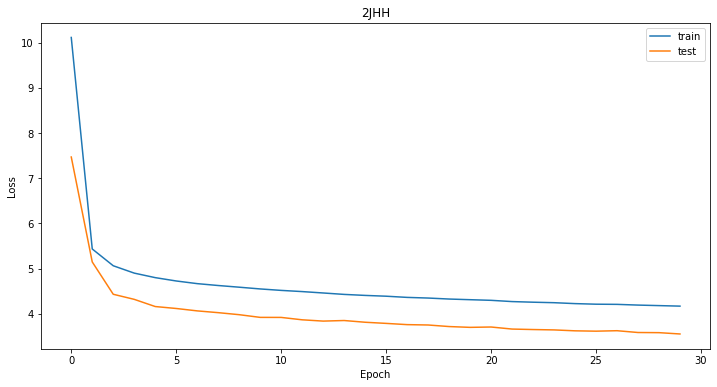

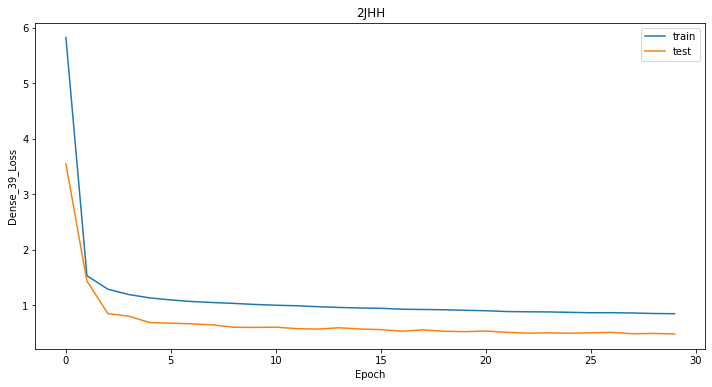

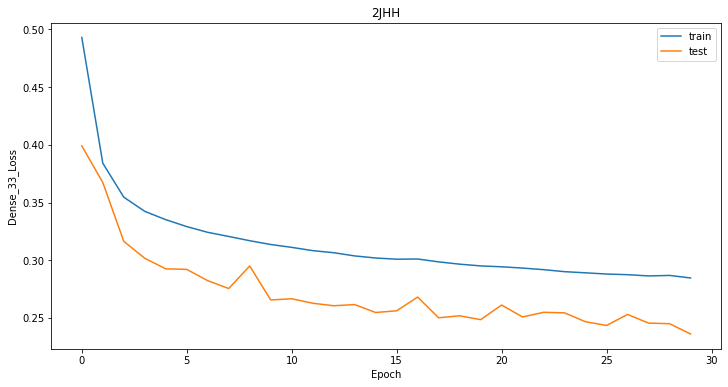

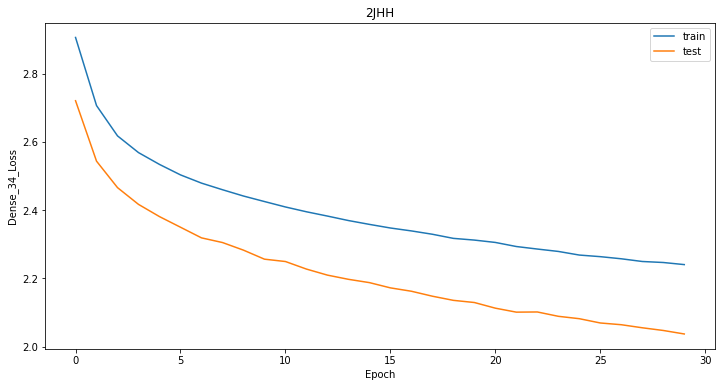

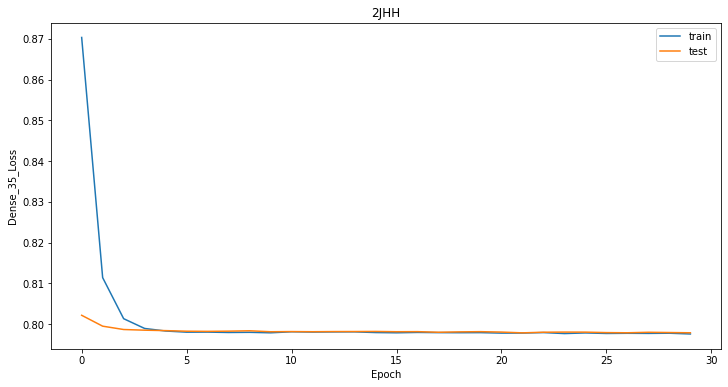

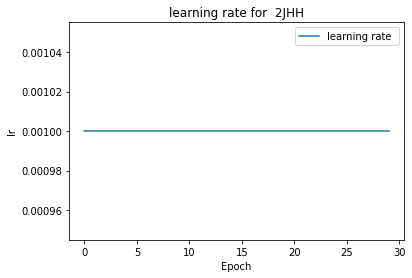


 14%|█▍        | 1/7 [03:05<18:32, 185.46s/it]


 /content/drive/MyDrive/mole/neural_net/molecule_model_1JHN.hdf5
Training 1JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 39312 samples, validate on 4368 samples
Epoch 1/30
39312/39312 [==============================] - 2s 62us/step - loss: 50.3336 - dense_13_loss: 46.6785 - dense_7_loss: 0.8574 - dense_8_loss: 1.7905 - dense_9_loss: 0.9649 - val_loss: 51.8806 - val_dense_13_loss: 48.8363 - val_dense_7_loss: 0.7717 - val_dense_8_loss: 1.6425 - val_dense_9_loss: 0.6756
Epoch 2/30
39312/39312 [==============================] - 1s 16us/step - loss: 48.2507 - dense_13_loss: 45.4481 - dense_7_loss: 0.5942 - dense_8_loss: 1.5039 - dense_9_loss: 0.7230 - val_loss: 50.2841 - val_dense_13_loss: 47.7575 - val_dense_7_loss: 0.6085 - val_dense_8_loss: 1.3874 - val_dense_9_loss: 0.6242
Epoch 3/30
39312/39312 [==============================] - 1s 15us/step - loss: 46.8737 - dense_13_loss: 44.2323 - dense_7_loss: 0.5226 - dense_8_loss: 1.4162 - dense_9_loss: 0.6669 -

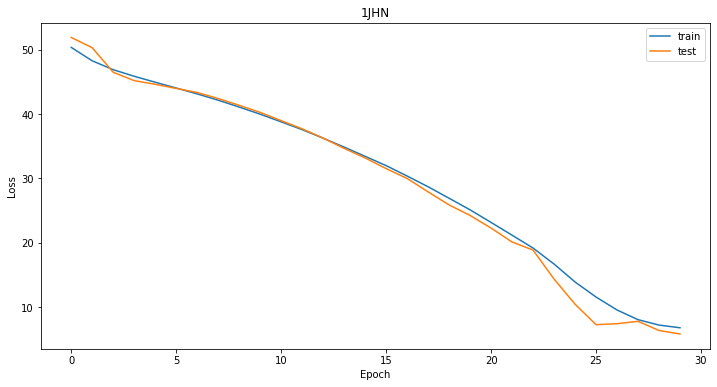

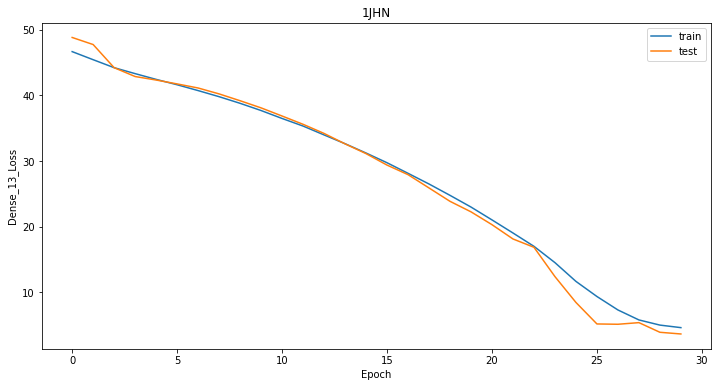

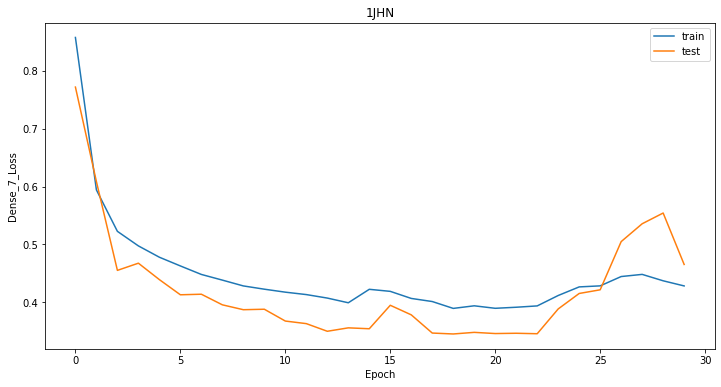

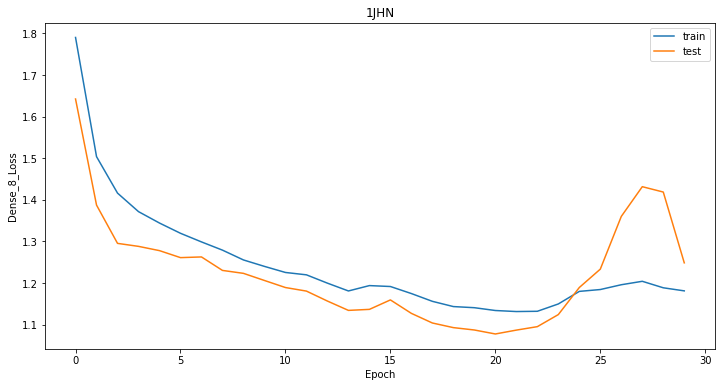

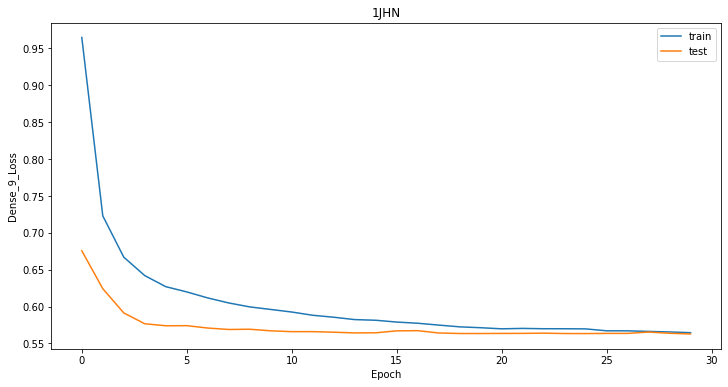

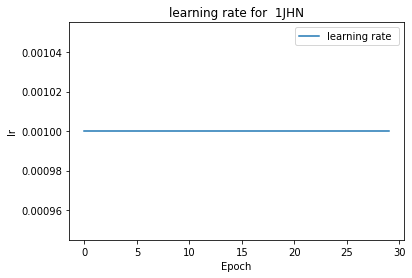


 29%|██▊       | 2/7 [03:48<11:52, 142.59s/it]


 /content/drive/MyDrive/mole/neural_net/molecule_model_2JHN.hdf5
Training 2JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 107153 samples, validate on 11906 samples
Epoch 1/30
107153/107153 [==============================] - 3s 31us/step - loss: 5.3249 - dense_13_loss: 2.4513 - dense_7_loss: 0.6501 - dense_8_loss: 1.5916 - dense_9_loss: 0.6184 - val_loss: 4.4296 - val_dense_13_loss: 2.1545 - val_dense_7_loss: 0.4971 - val_dense_8_loss: 1.3697 - val_dense_9_loss: 0.4113
Epoch 2/30
107153/107153 [==============================] - 2s 15us/step - loss: 3.7341 - dense_13_loss: 1.3599 - dense_7_loss: 0.5017 - dense_8_loss: 1.3948 - dense_9_loss: 0.4764 - val_loss: 3.4745 - val_dense_13_loss: 1.3357 - val_dense_7_loss: 0.4308 - val_dense_8_loss: 1.3196 - val_dense_9_loss: 0.3897
Epoch 3/30
107153/107153 [==============================] - 2s 15us/step - loss: 3.3643 - dense_13_loss: 1.1265 - dense_7_loss: 0.4595 - dense_8_loss: 1.3263 - dense_9_loss: 0.4501 - v

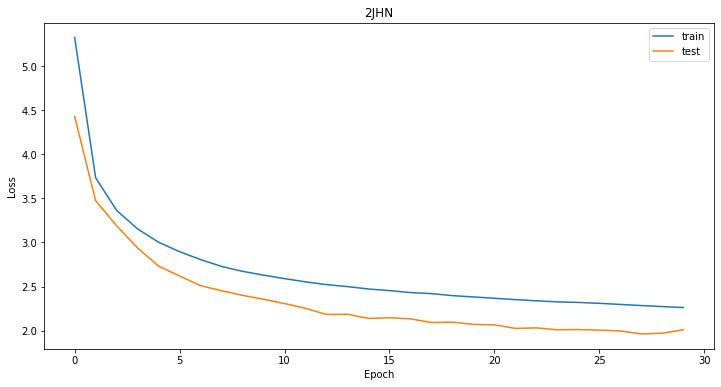

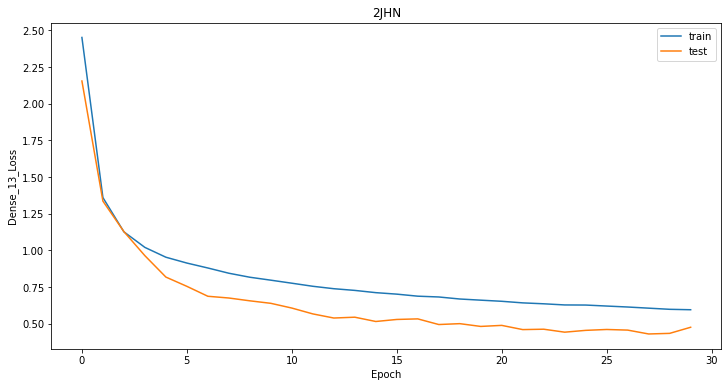

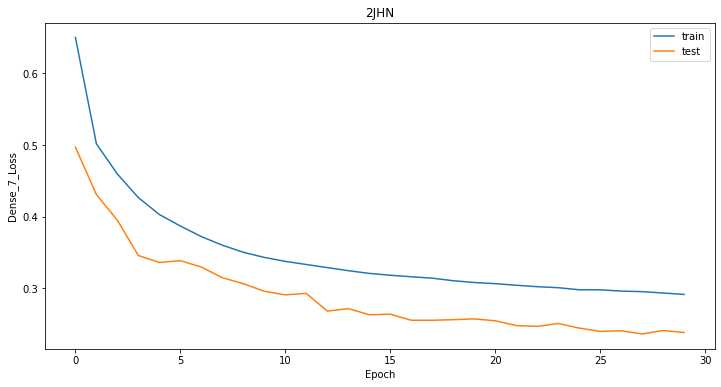

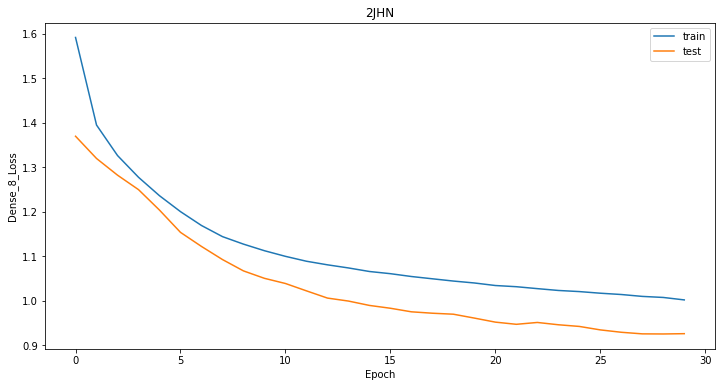

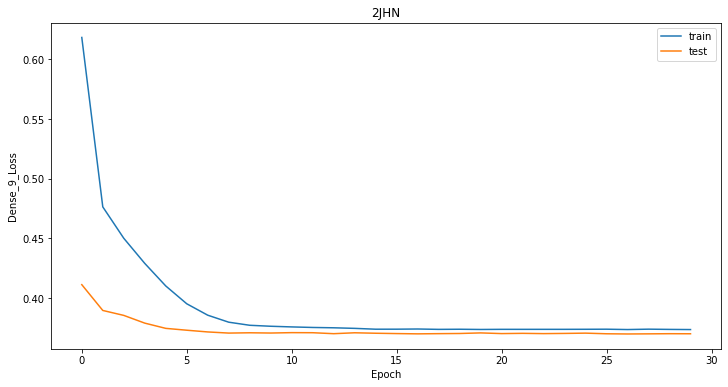

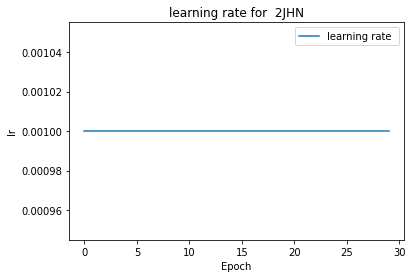


 43%|████▎     | 3/7 [04:58<08:04, 121.10s/it]


 /content/drive/MyDrive/mole/neural_net/molecule_model_2JHC.hdf5
Training 2JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 



ValueError: ignored

In [ ]:
mol_types=df_train["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 30
verbose = 1
batch_size = 2048
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True


# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

start_time=datetime.now()

# Loop through each molecule type in temp list
for mol_type in tqdm(temp_a): #podmienilem

    
    model_name_rd = ('/content/drive/MyDrive/mole/neural_net/molecule_model_%s.hdf5' % mol_type)
    model_name_wrt = ('/content/drive/MyDrive/mole/neural_net/molecule_model_%s.hdf5' % mol_type)
    print('\n',model_name_wrt)
    
    print('Training %s' % mol_type, 'out of', mol_types, '\n')
    
    df_train_=df_train[df_train["type"]==mol_type]
    df_test_=df_test[df_test["type"]==mol_type]
    
    # Here's our best features.  We think.
    input_features=["x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z",
                    'x_closest_0','y_closest_0','z_closest_0','x_closest_1','y_closest_1','z_closest_1',
                    "distance","distance_center0","distance_center1", "distance_c0","distance_c1","distance_f0","distance_f1",
                    "cos_c0_c1","cos_f0_f1","cos_center0_center1","cos_c0","cos_c1","cos_f0","cos_f1","cos_center0","cos_center1",
                    "atom_n"
                   ]
    
    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
    
    target_data=df_train_.loc[:,"scalar_coupling_constant"].values
    target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
    target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
    target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
    
    #following parameters should be adjusted to control the loss function
    #if all parameters are zero, attractors do not work. (-> simple neural network)
    m1=1 
    m2=4
    m3=1 
    target_data_1=m1*(StandardScaler().fit_transform(target_data_1))
    target_data_2=m2*(StandardScaler().fit_transform(target_data_2))
    target_data_3=m3*(StandardScaler().fit_transform(target_data_3))
    
    # Simple split to provide us a validation set to do our CV checks with
    train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
    
    # Split all our input and targets by train and cv indexes
    train_input=input_data[train_index]
    cv_input=input_data[cv_index]
    train_target=target_data[train_index]
    cv_target=target_data[cv_index]
    train_target_1=target_data_1[train_index]
    cv_target_1=target_data_1[cv_index]
    train_target_2=target_data_2[train_index]
    cv_target_2=target_data_2[cv_index]
    train_target_3=target_data_3[train_index]
    cv_target_3=target_data_3[cv_index]
    test_input=input_data[len(df_train_):,:]

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=8,verbose=1, mode='auto', restore_best_weights=True) # bylo 0001 min delta
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10, min_lr=1e-6, mode='min', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True)
    cal1=[es, rlr, sv_mod]

    # history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
    #         validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
    #         callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
            validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
            callbacks=cal1, epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    # plot_history(history, mol_type) previous plot fuction
    print('\n =============== Plots for dense Layers for {}'.format(mol_type))
    plot_all(history, mol_type)
    
    accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
    K.clear_session()

cv_score_total/=len(mol_types)



# 9. Model summary

Losses plots are not bad for first approach the most desirable ar efor 1HN molecule type. For the others there is need to work with NN structure droput normaluisation extra or less layers so training and test curves ar eclose each other. At leat there are no obvious signs of overfitting

In [ ]:
nn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          8448        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256)          1024        dense[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256)          0           batch_normalization[0][0]        
______________________________________________________________________________________________

# TF 2x.

# challenges

to calculate in a standard colab environment code was ajusted to tensorflow 2.x 
Dictionary where model is saving losses has a bit diffrent structure so the plot_all funcion was changed a bit

In [ ]:
# for TF 2.x history dictionary is created a bit diffrent that s why new function for plotting
def plot_all_2(history, mol_type):

  hist=list(history.history.keys()) 
  hist_l6=hist[:4]

  for key in hist_l6:
    draw_learning_curve(history,  mol_type, key=key)
    print()
  plot_history_lr(history, mol_type)

In [ ]:
temp_a= ['2JHH', '1JHN', '2JHN',  '3JHH',  '3JHN']

Lets make functions to be more clear and compact

In [ ]:
# setup for TF 2.x
# Set up GPU preferences
# and then replace:
# tf.ConfigProto by tf.compat.v1.ConfigProto
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
# moja wstawka ponizej
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session(config=config)
# sess = tf.Session(config=config)  #bylo w orginale
# K.set_session(sess) #bylo
tf.compat.v1.keras.backend.set_session(sess)

start_time=datetime.now()

In [ ]:
def train_plot_save(mol_types, work_dir, epoch_n=30, verbose=1, batch_size = 2048, retrain =True ):
  cv_score=[]
  cv_score_total=0


  # Loop through each molecule type
  for mol_type in tqdm(mol_types):  

      
      model_name_rd = (work_dir+'/molecule_model_%s.hdf5' % mol_type)
      model_name_wrt = (work_dir+'/molecule_model_%s.hdf5' % mol_type)
      print('Training %s' % mol_type, 'out of', mol_types, '\n')
      
      df_train_=df_train[df_train["type"]==mol_type]
      df_test_=df_test[df_test["type"]==mol_type]
      
      # Here's our best features.  We think.
      input_features=["x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z",
                      'x_closest_0','y_closest_0','z_closest_0','x_closest_1','y_closest_1','z_closest_1',
                      "distance","distance_center0","distance_center1", "distance_c0","distance_c1","distance_f0","distance_f1",
                      "cos_c0_c1","cos_f0_f1","cos_center0_center1","cos_c0","cos_c1","cos_f0","cos_f1","cos_center0","cos_center1",
                      "atom_n"
                    ]
      
      # Standard Scaler from sklearn does seem to work better here than other Scalers
      input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
      
      target_data=df_train_.loc[:,"scalar_coupling_constant"].values
      target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
      target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
      target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
      
      #following parameters should be adjusted to control the loss function
      #if all parameters are zero, attractors do not work. (-> simple neural network)
      m1=1
      m2=4
      m3=1
      target_data_1=m1*(StandardScaler().fit_transform(target_data_1))
      target_data_2=m2*(StandardScaler().fit_transform(target_data_2))
      target_data_3=m3*(StandardScaler().fit_transform(target_data_3))
      
      # Simple split to provide us a validation set to do our CV checks with
      train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
      
      # Split all our input and targets by train and cv indexes
      train_input=input_data[train_index]
      cv_input=input_data[cv_index]
      train_target=target_data[train_index]
      cv_target=target_data[cv_index]
      train_target_1=target_data_1[train_index]
      cv_target_1=target_data_1[cv_index]
      train_target_2=target_data_2[train_index]
      cv_target_2=target_data_2[cv_index]
      train_target_3=target_data_3[train_index]
      cv_target_3=target_data_3[cv_index]
      test_input=input_data[len(df_train_):,:]

      # Build the Neural Net
      nn_model=create_nn_model_1(train_input.shape[1])
      
      # If retrain==False, then we load a previous saved model as a starting point.
      if not retrain:
          nn_model = load_model(model_name_rd)
          
      nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
      
      # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
      es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=8,verbose=1, mode='auto', restore_best_weights=True)
      # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
      rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=7, min_lr=1e-6, mode='auto', verbose=1)
      # Save the best value of the model for future use
      sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True) # wykosilem period=1

      history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
              validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
              callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
      
      cv_predict=nn_model.predict(cv_input)
      
      # plot_history(history, mol_type) previous plot fuction
      print('\n =============== Plots for dense Layers for {}'.format(mol_type))
      
      plot_all_2(history, mol_type)
      
      accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
      cv_score.append(np.log(accuracy))
      cv_score_total+=np.log(accuracy)
      
      # Predict on the test data set using our trained model
      test_predict=nn_model.predict(test_input)
      
      # for each molecule type we'll grab the predicted values
      test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
      # K.clear_session() #was
      tf.compat.v1.keras.backend.clear_session() 

  cv_score_total/=len(mol_types)

In [ ]:
#setup for calculation
# mol_types=df_train["type"].unique() clarification of problems without JHC
mol_types= ['2JHH', '1JHN', '2JHN',  '3JHH',  '3JHN', '3JHC']

epoch_n = 30 # was 300
verbose = 1 # to see on which epoch there are problems
batch_size = 2048
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True
work_dir ='/content/drive/MyDrive/mole/neural_net_2x'







  0%|          | 0/5 [00:00<?, ?it/s]

Training 2JHH out of ['2JHH', '1JHN', '2JHN', '3JHH', '3JHN'] 

Train on 340189 samples, validate on 37799 samples
Epoch 1/30
340189/340189 [==============================] - 13s 39us/sample - loss: 10.8168 - dense_12_loss: 6.4131 - dense_6_loss: 0.5183 - dense_7_loss: 2.9839 - dense_8_loss: 0.8811 - val_loss: 8.0099 - val_dense_12_loss: 4.0854 - val_dense_6_loss: 0.3761 - val_dense_7_loss: 2.7497 - val_dense_8_loss: 0.8006
Epoch 2/30
340189/340189 [==============================] - 11s 33us/sample - loss: 5.6244 - dense_12_loss: 1.6497 - dense_6_loss: 0.4026 - dense_7_loss: 2.7545 - dense_8_loss: 0.8167 - val_loss: 5.3623 - val_dense_12_loss: 1.6117 - val_dense_6_loss: 0.3575 - val_dense_7_loss: 2.5956 - val_dense_8_loss: 0.7996
Epoch 3/30
340189/340189 [==============================] - 11s 31us/sample - loss: 5.1828 - dense_12_loss: 1.3414 - dense_6_loss: 0.3695 - dense_7_loss: 2.6695 - dense_8_loss: 0.8025 - val_loss: 4.7314 - val_dense_12_loss: 1.0731 - val_dense_6_loss: 0.3364 - 

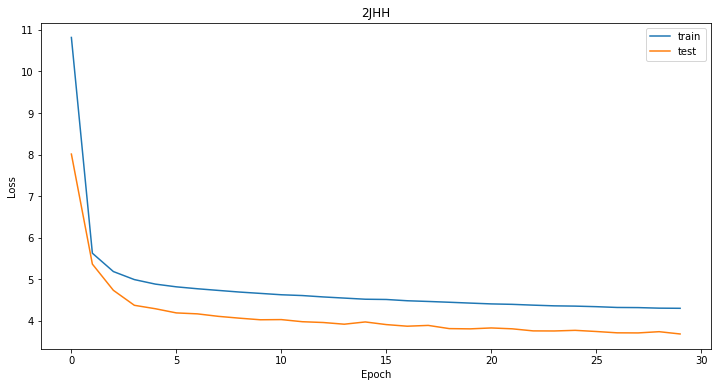

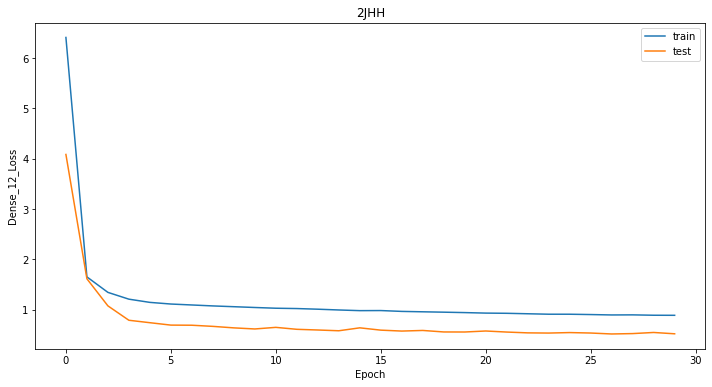

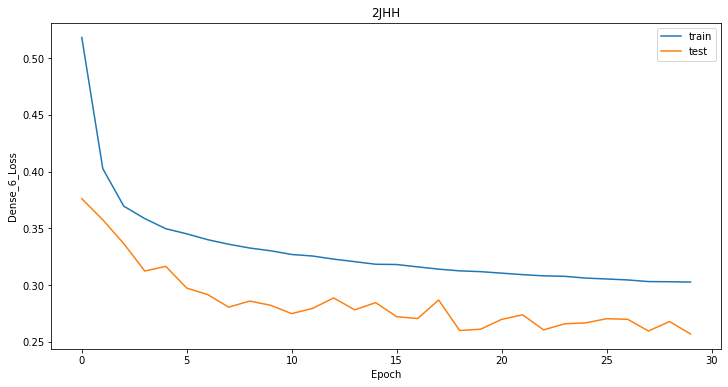

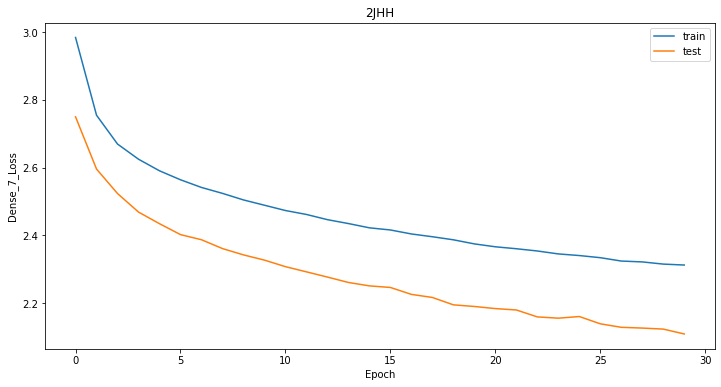

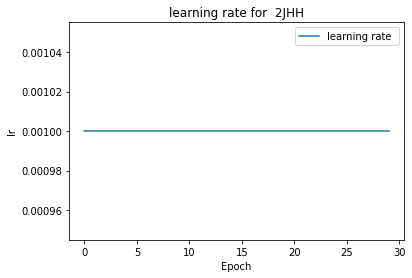







 20%|██        | 1/5 [06:00<24:00, 360.18s/it]

Training 1JHN out of ['2JHH', '1JHN', '2JHN', '3JHH', '3JHN'] 

Train on 39312 samples, validate on 4368 samples
Epoch 1/30
39312/39312 [==============================] - 5s 115us/sample - loss: 51.0321 - dense_12_loss: 47.2799 - dense_6_loss: 0.8964 - dense_7_loss: 1.8641 - dense_8_loss: 0.9545 - val_loss: 55.6950 - val_dense_12_loss: 52.3582 - val_dense_6_loss: 0.7141 - val_dense_7_loss: 1.6102 - val_dense_8_loss: 0.7345
Epoch 2/30
39312/39312 [==============================] - 1s 38us/sample - loss: 48.9199 - dense_12_loss: 45.9327 - dense_6_loss: 0.6263 - dense_7_loss: 1.5985 - dense_8_loss: 0.7314 - val_loss: 52.9833 - val_dense_12_loss: 50.4401 - val_dense_6_loss: 0.5527 - val_dense_7_loss: 1.4414 - val_dense_8_loss: 0.6224
Epoch 3/30
39312/39312 [==============================] - 2s 38us/sample - loss: 47.5379 - dense_12_loss: 44.7717 - dense_6_loss: 0.5694 - dense_7_loss: 1.4889 - dense_8_loss: 0.6691 - val_loss: 47.7984 - val_dense_12_loss: 46.1371 - val_dense_6_loss: 0.4767 -

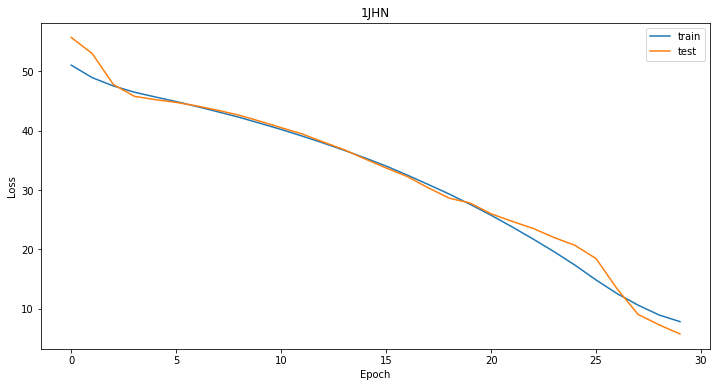

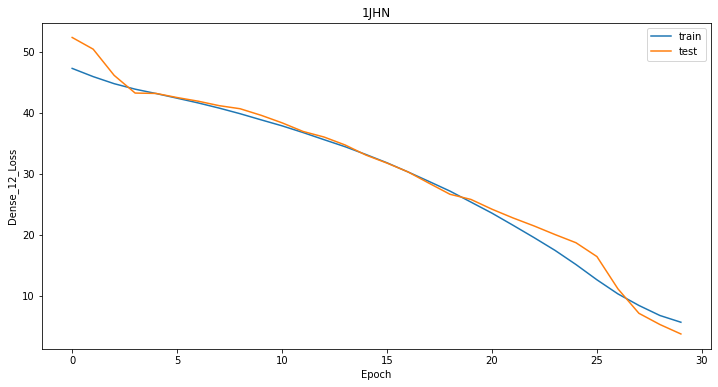

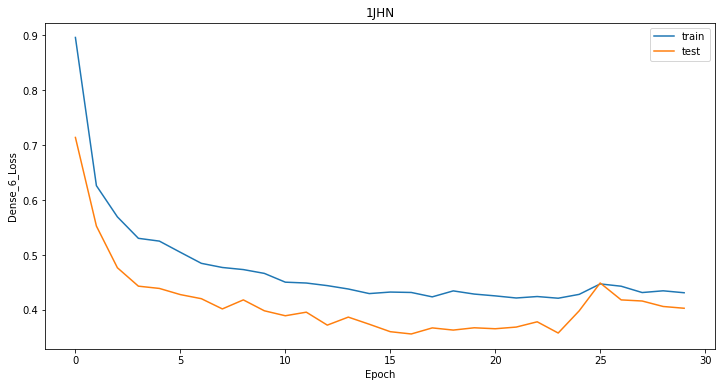

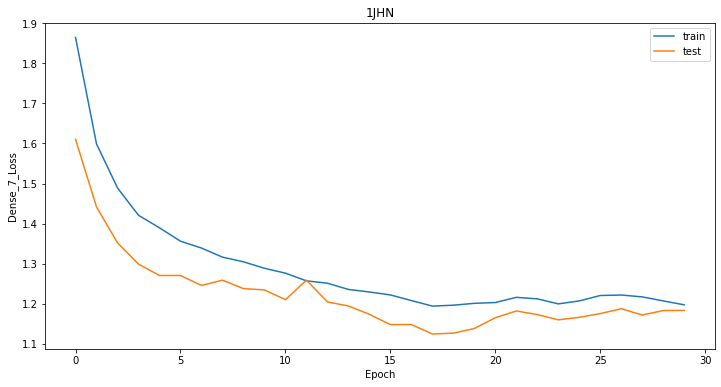

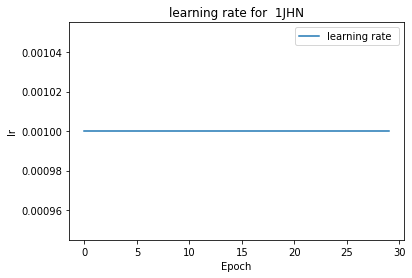







 40%|████      | 2/5 [06:59<13:29, 269.94s/it]

Training 2JHN out of ['2JHH', '1JHN', '2JHN', '3JHH', '3JHN'] 

Train on 107153 samples, validate on 11906 samples
Epoch 1/30
107153/107153 [==============================] - 6s 61us/sample - loss: 5.7590 - dense_12_loss: 2.8091 - dense_6_loss: 0.6621 - dense_7_loss: 1.6477 - dense_8_loss: 0.6219 - val_loss: 5.1635 - val_dense_12_loss: 2.7794 - val_dense_6_loss: 0.5497 - val_dense_7_loss: 1.4323 - val_dense_8_loss: 0.4077
Epoch 2/30
107153/107153 [==============================] - 4s 34us/sample - loss: 3.9233 - dense_12_loss: 1.4769 - dense_6_loss: 0.5178 - dense_7_loss: 1.4419 - dense_8_loss: 0.4834 - val_loss: 3.6988 - val_dense_12_loss: 1.5016 - val_dense_6_loss: 0.4509 - val_dense_7_loss: 1.3597 - val_dense_8_loss: 0.3873
Epoch 3/30
107153/107153 [==============================] - 4s 34us/sample - loss: 3.5250 - dense_12_loss: 1.2156 - dense_6_loss: 0.4858 - dense_7_loss: 1.3705 - dense_8_loss: 0.4533 - val_loss: 3.3354 - val_dense_12_loss: 1.2125 - val_dense_6_loss: 0.4201 - val_

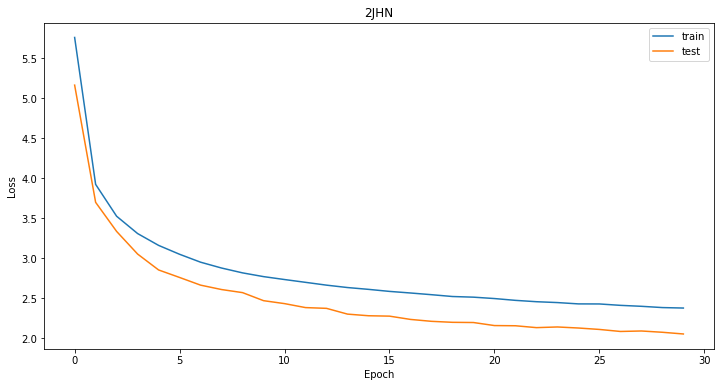

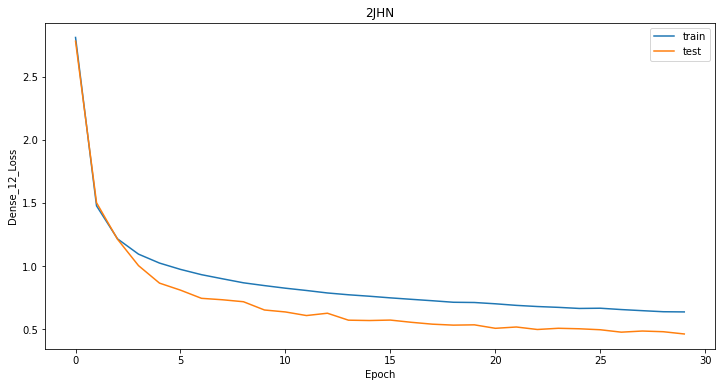

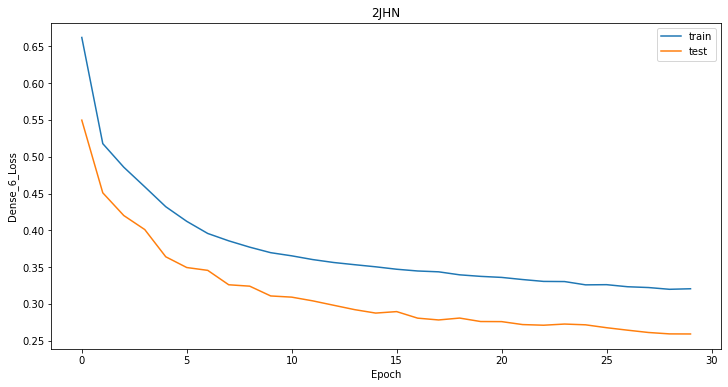

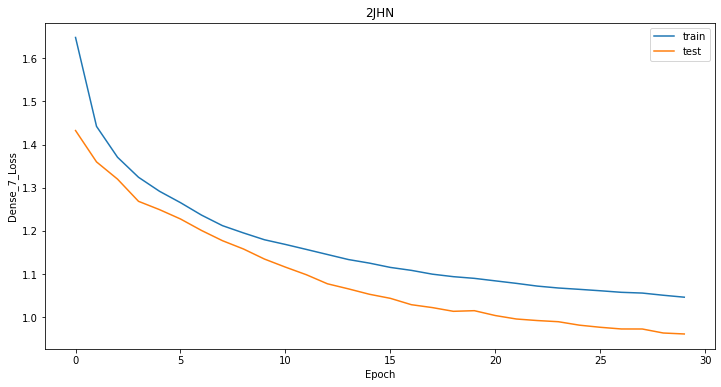

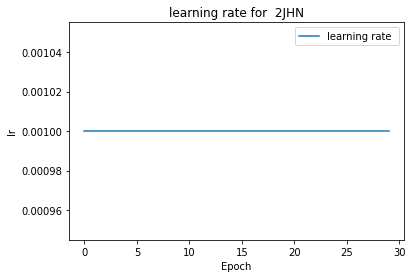







 60%|██████    | 3/5 [09:07<07:34, 227.36s/it]

Training 3JHH out of ['2JHH', '1JHN', '2JHN', '3JHH', '3JHN'] 

Train on 531476 samples, validate on 59053 samples
Epoch 1/30
531476/531476 [==============================] - 19s 37us/sample - loss: 6.3659 - dense_12_loss: 2.1044 - dense_6_loss: 0.5077 - dense_7_loss: 2.9321 - dense_8_loss: 0.8198 - val_loss: 5.1068 - val_dense_12_loss: 1.2074 - val_dense_6_loss: 0.3893 - val_dense_7_loss: 2.7578 - val_dense_8_loss: 0.7518
Epoch 2/30
531476/531476 [==============================] - 18s 34us/sample - loss: 5.1785 - dense_12_loss: 1.2335 - dense_6_loss: 0.4146 - dense_7_loss: 2.7725 - dense_8_loss: 0.7577 - val_loss: 4.6813 - val_dense_12_loss: 0.9386 - val_dense_6_loss: 0.3643 - val_dense_7_loss: 2.6277 - val_dense_8_loss: 0.7507
Epoch 3/30
531476/531476 [==============================] - 17s 32us/sample - loss: 4.9546 - dense_12_loss: 1.1251 - dense_6_loss: 0.3847 - dense_7_loss: 2.6921 - dense_8_loss: 0.7528 - val_loss: 4.4520 - val_dense_12_loss: 0.8561 - val_dense_6_loss: 0.3110 - v

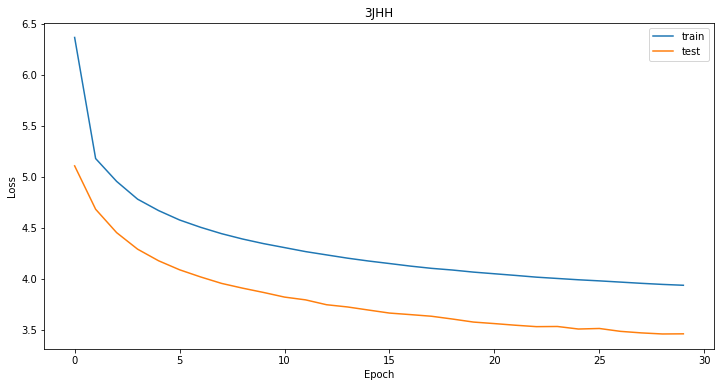

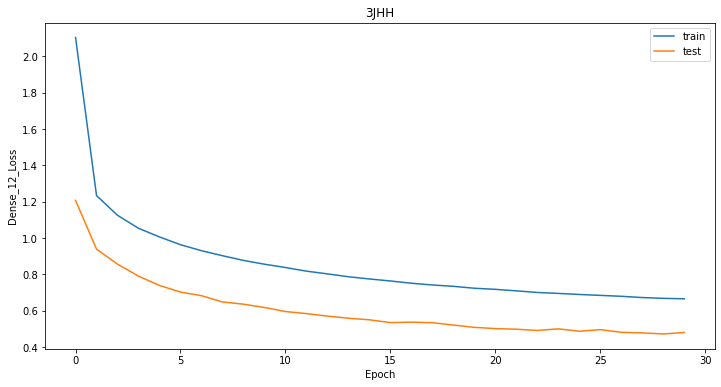

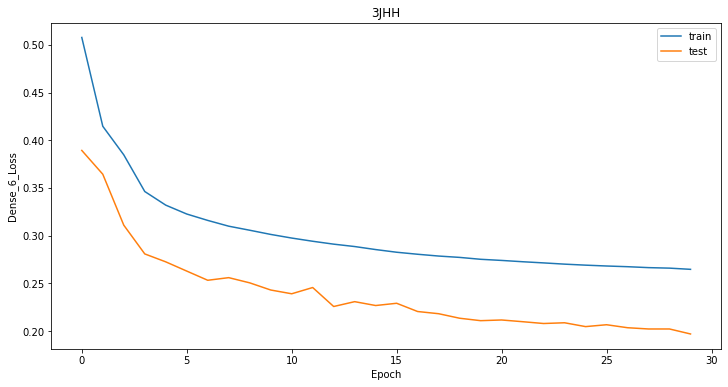

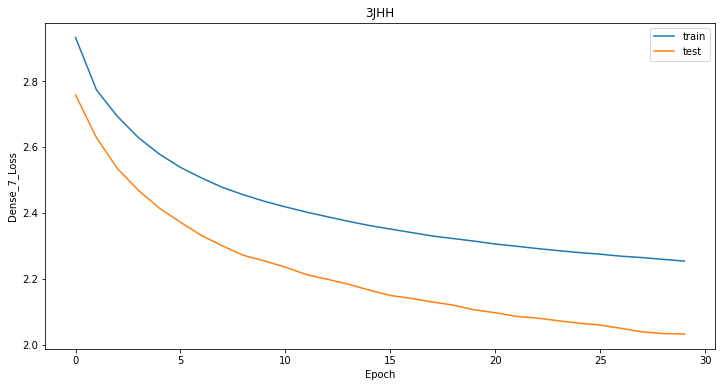

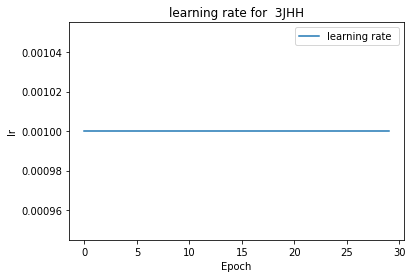







 80%|████████  | 4/5 [18:47<05:33, 333.23s/it]

Training 3JHN out of ['2JHH', '1JHN', '2JHN', '3JHH', '3JHN'] 

Train on 149951 samples, validate on 16662 samples
Epoch 1/30
149951/149951 [==============================] - 8s 53us/sample - loss: 3.9521 - dense_12_loss: 0.9911 - dense_6_loss: 0.6824 - dense_7_loss: 1.6925 - dense_8_loss: 0.5824 - val_loss: 3.4131 - val_dense_12_loss: 0.9925 - val_dense_6_loss: 0.5271 - val_dense_7_loss: 1.5063 - val_dense_8_loss: 0.3961
Epoch 2/30
149951/149951 [==============================] - 5s 34us/sample - loss: 3.2854 - dense_12_loss: 0.8139 - dense_6_loss: 0.5188 - dense_7_loss: 1.5007 - dense_8_loss: 0.4503 - val_loss: 2.8902 - val_dense_12_loss: 0.6979 - val_dense_6_loss: 0.3955 - val_dense_7_loss: 1.4063 - val_dense_8_loss: 0.3798
Epoch 3/30
149951/149951 [==============================] - 5s 34us/sample - loss: 3.0264 - dense_12_loss: 0.7224 - dense_6_loss: 0.4590 - dense_7_loss: 1.4234 - dense_8_loss: 0.4214 - val_loss: 2.7479 - val_dense_12_loss: 0.6436 - val_dense_6_loss: 0.3758 - val_

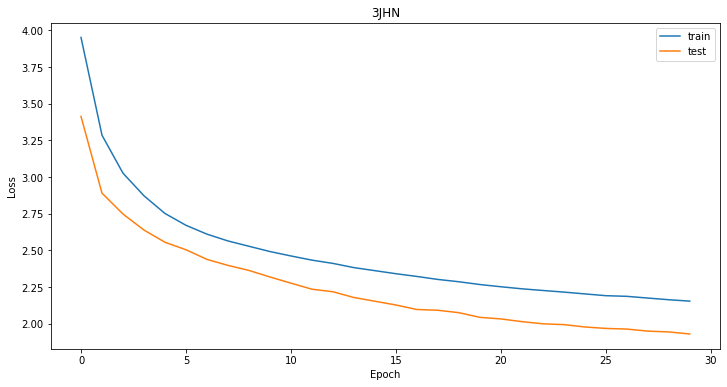

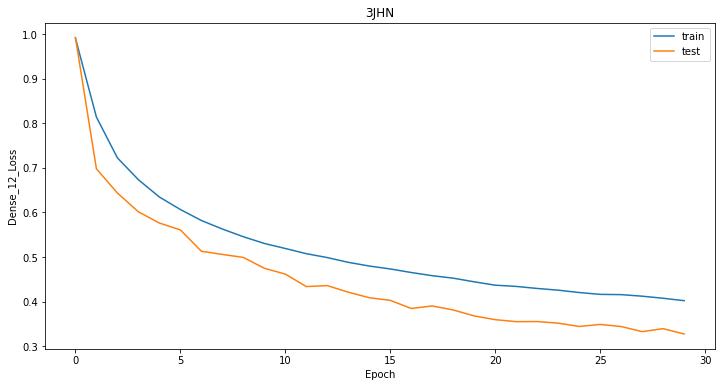

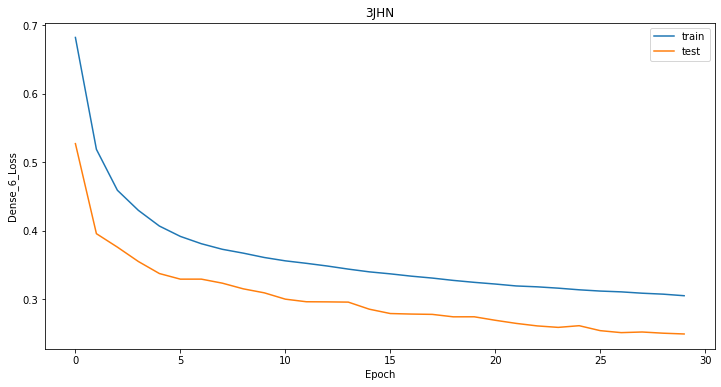

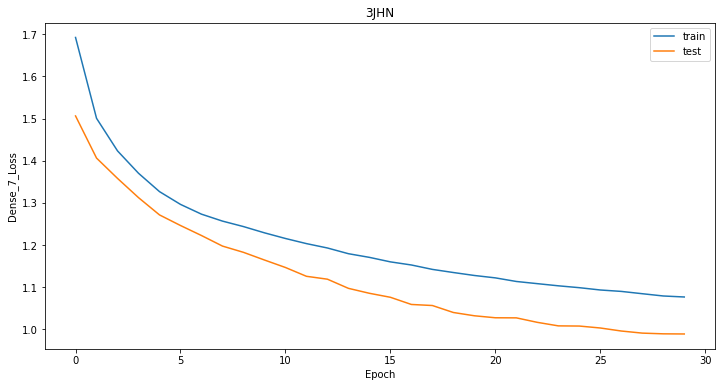

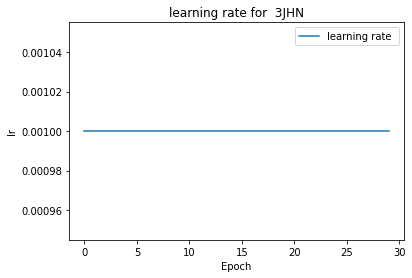







100%|██████████| 5/5 [21:43<00:00, 260.63s/it]


In [ ]:
train_plot_save(mol_types, work_dir, epoch_n=30, verbose=1, batch_size = 2048, retrain =True )

There are two problematic types ie '1JHC', '2JHC'

1JHC generates NaNs 


```
18786/18786 [==============================] - 2s 87us/sample - loss: nan - dense_25_loss: nan - dense_19_loss: nan - dense_20_loss: nan - dense_21_loss: nan - val_loss: nan - val_dense_25_loss: nan - val_dense_19_loss: nan
```



Regression with neural networks is hard to get working because the output is unbounded, so you are especially prone to the exploding gradients problem (the likely cause of the nans).

Historically, one key solution to exploding gradients was to reduce the learning rate, but with the advent of per-parameter adaptive learning rate algorithms like Adam, you no longer need to set a learning rate to get good performance. There is very little reason to use SGD with momentum anymore unless you're a neural network fiend and know how to tune the learning schedule.


---

Here are some things I  could potentially try:

* Normalize  outputs by quantile normalizing or z scoring. To be rigorous, compute this transformation on the training data, not on the entire dataset. For example, with quantile normalization, if an example is in the 60th percentile of the training set, it gets a value of 0.6. (You can also shift the quantile normalized values down by 0.5 so that the 0th percentile is -0.5 and the 100th percentile is +0.5).
 
* Add regularization, either by increasing the dropout rate or adding L1 and L2 penalties to the weights. L1 regularization is analogous to feature selection, and since you said that reducing the number of features to 5 gives good performance, L1 may also.
 
* If these still don't help, reduce the size of the network. This is not always the best idea since it can harm performance, but in your case you have a large number of first-layer neurons (1024) relative to input features (35) so it may help.
 
* Increase the batch size from 32 to 128. 128 is fairly standard and could potentially increase the stability of the optimization.

In [ ]:
#setup for calculation
# mol_types=df_train["type"].unique() clarification of problems without JHC
mol_types= ['1JHC', '2JHC']

epoch_n = 30 # was 300
verbose = 1 # to see on which epoch there are problems
batch_size = 2048
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True
work_dir ='/content/drive/MyDrive/mole/neural_net_2xa'

In [ ]:
def train_plot_save_1(mol_types, work_dir, epoch_n=30, verbose=1, batch_size = 2048, retrain =True ):
  cv_score=[]
  cv_score_total=0


  # Loop through each molecule type
  for mol_type in tqdm(mol_types):  

      
      model_name_rd = (work_dir+'/molecule_model_%s.hdf5' % mol_type)
      model_name_wrt = (work_dir+'/molecule_model_%s.hdf5' % mol_type)
      print('Training %s' % mol_type, 'out of', mol_types, '\n')
      
      df_train_=df_train[df_train["type"]==mol_type]
      df_test_=df_test[df_test["type"]==mol_type]
      
      # Here's our best features.  We think.
      input_features=["x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z",
                      'x_closest_0','y_closest_0','z_closest_0','x_closest_1','y_closest_1','z_closest_1',
                      "distance","distance_center0","distance_center1", "distance_c0","distance_c1","distance_f0","distance_f1",
                      "cos_c0_c1","cos_f0_f1","cos_center0_center1","cos_c0","cos_c1","cos_f0","cos_f1","cos_center0","cos_center1",
                      "atom_n"
                    ]
      
      # Standard Scaler from sklearn does seem to work better here than other Scalers
      input_data=MinMaxScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
      
      target_data=df_train_.loc[:,"scalar_coupling_constant"].values
      target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
      target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
      target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
      
      #following parameters should be adjusted to control the loss function
      #if all parameters are zero, attractors do not work. (-> simple neural network)
      m1=1
      m2=4
      m3=1
      target_data_1=m1*(MinMaxScaler().fit_transform(target_data_1))
      target_data_2=m2*(MinMaxScaler().fit_transform(target_data_2))
      target_data_3=m3*(MinMaxScaler().fit_transform(target_data_3))
      
      # Simple split to provide us a validation set to do our CV checks with
      train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
      
      # Split all our input and targets by train and cv indexes
      train_input=input_data[train_index]
      cv_input=input_data[cv_index]
      train_target=target_data[train_index]
      cv_target=target_data[cv_index]
      train_target_1=target_data_1[train_index]
      cv_target_1=target_data_1[cv_index]
      train_target_2=target_data_2[train_index]
      cv_target_2=target_data_2[cv_index]
      train_target_3=target_data_3[train_index]
      cv_target_3=target_data_3[cv_index]
      test_input=input_data[len(df_train_):,:]

      # Build the Neural Net
      nn_model=create_nn_model_1(train_input.shape[1])
      
      # If retrain==False, then we load a previous saved model as a starting point.
      if not retrain:
          nn_model = load_model(model_name_rd)
          
      nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
      
      # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
      es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=8,verbose=1, mode='auto', restore_best_weights=True)
      # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
      rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=7, min_lr=1e-6, mode='auto', verbose=1)
      # Save the best value of the model for future use
      sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True) # wykosilem period=1

      history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
              validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
              callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
      
      cv_predict=nn_model.predict(cv_input)
      
      # plot_history(history, mol_type) previous plot fuction
      print('\n =============== Plots for dense Layers for {}'.format(mol_type))
      
      plot_all_2(history, mol_type)
      
      accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
      cv_score.append(np.log(accuracy))
      cv_score_total+=np.log(accuracy)
      
      # Predict on the test data set using our trained model
      test_predict=nn_model.predict(test_input)
      
      # for each molecule type we'll grab the predicted values
      test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
      # K.clear_session() #was
      tf.compat.v1.keras.backend.clear_session() 

  cv_score_total/=len(mol_types)

In [ ]:
train_plot_save_1(mol_types, work_dir, epoch_n=30, verbose=1, batch_size = 2048, retrain =True )


  0%|          | 0/2 [00:00<?, ?it/s]

Training 1JHC out of ['1JHC', '2JHC'] 

Train on 638219 samples, validate on 70914 samples
Epoch 1/30
638219/638219 [==============================] - 12s 19us/sample - loss: nan - dense_25_loss: nan - dense_19_loss: nan - dense_20_loss: nan - dense_21_loss: nan - val_loss: nan - val_dense_25_loss: nan - val_dense_19_loss: nan - val_dense_20_loss: nan - val_dense_21_loss: nan
Epoch 2/30
638219/638219 [==============================] - 11s 17us/sample - loss: nan - dense_25_loss: nan - dense_19_loss: nan - dense_20_loss: nan - dense_21_loss: nan - val_loss: nan - val_dense_25_loss: nan - val_dense_19_loss: nan - val_dense_20_loss: nan - val_dense_21_loss: nan
Epoch 3/30
638219/638219 [==============================] - 11s 17us/sample - loss: nan - dense_25_loss: nan - dense_19_loss: nan - dense_20_loss: nan - dense_21_loss: nan - val_loss: nan - val_dense_25_loss: nan - val_dense_19_loss: nan - val_dense_20_loss: nan - val_dense_21_loss: nan
Epoch 4/30
638219/638219 [===================

TypeError: ignored

In [ ]:
df_train[df_train["type"]== "1JHC"].sample(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,charge_0,XX_0,YX_0,ZX_0,XY_0,YY_0,ZY_0,XZ_0,YZ_0,ZZ_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z,atom_n,charge_1,XX_1,YX_1,ZX_1,XY_1,YY_1,ZY_1,XZ_1,YZ_1,ZZ_1,dx,dy,...,distance,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,max_distance_x,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,max_distance_y,atom_index_farthest_0,distance_farthest_0,x_farthest_0,y_farthest_0,z_farthest_0,min_distance_x,atom_index_farthest_1,distance_farthest_1,x_farthest_1,y_farthest_1,z_farthest_1,min_distance_y,distance_center0,distance_center1,distance_c0,distance_c1,distance_f0,distance_f1,cos_c0_c1,cos_f0_f1,cos_center0_center1,cos_c0,cos_c1,cos_f0,cos_f1,cos_center0,cos_center1
2955822,2955822,dsgdb9nsd_087189,16,5,1JHC,82.5000,H,-0.468994,-1.817383,2.406250,0.137451,29.218750,-0.048096,1.818359,1.197266,25.109375,1.786133,0.808105,0.308594,32.187500,C,0.158203,-2.060547,1.538086,0.658691,-1.154297,0.895996,19,-0.397217,169.750,6.371094,11.781250,-0.136475,143.0000,7.683594,5.585938,-3.148438,131.8750,0.626953,-0.243164,...,1.098633,5,1.098633,0.158203,-2.060547,1.538086,3.494141,17,1.093750,-0.483643,-2.548828,0.797852,3.498047,2,3.494141,1.204102,-0.736328,-0.465820,1.098633,14,3.498047,2.103516,-0.163086,-0.664062,1.093750,1.998047,1.218750,1.098633,1.093750,3.494141,3.498047,0.298828,0.951660,0.876953,-0.999023,-0.298828,-0.854004,-0.694824,-0.845703,-0.486084
4380166,4380166,dsgdb9nsd_121709,15,3,1JHC,84.7500,H,-0.987305,-2.478516,0.800293,0.141968,30.828125,-1.630859,0.312012,-2.537109,28.937500,0.658203,0.837891,2.240234,26.984375,C,-1.327148,-2.033203,-0.144531,-1.774414,-1.761719,-0.042328,18,-0.322754,180.125,4.371094,7.992188,16.281250,125.5625,2.626953,4.976562,0.875488,125.0000,-0.339844,0.445312,...,1.098633,3,1.098633,-1.327148,-2.033203,-0.144531,3.080078,14,1.098633,-0.607422,-2.378906,-0.898926,3.267578,13,3.080078,-1.643555,-0.070374,-1.001953,1.098633,16,3.267578,-3.111328,-4.343750,-1.610352,1.098633,1.357422,0.533203,1.098633,1.098633,3.080078,3.267578,0.260254,-0.174072,0.636230,-0.999023,-0.260254,-0.886230,-0.268066,-0.927734,-0.301025
602753,602753,dsgdb9nsd_019060,17,6,1JHC,86.6875,H,1.663086,-2.564453,-1.541992,0.056580,27.921875,-0.820312,3.863281,-1.231445,24.453125,-0.915527,2.699219,-0.394287,35.562500,C,1.270508,-2.244141,-0.577148,0.650879,-1.125000,0.283691,19,-0.045380,147.125,0.856445,21.156250,0.168457,142.7500,-5.250000,7.062500,-2.902344,154.8750,-0.392578,0.320312,...,1.089844,6,1.089844,1.270508,-2.244141,-0.577148,3.439453,17,1.089844,1.663086,-2.564453,-1.541992,3.259766,1,3.439453,-0.023544,0.004055,0.004730,1.089844,13,3.259766,1.109375,-0.173340,1.935547,1.089844,2.535156,1.541992,1.089844,1.089844,3.439453,3.259766,-1.000000,0.844727,0.974121,-1.000000,1.000000,-0.793945,-0.886719,-0.948242,-0.852051
352676,352676,dsgdb9nsd_012069,11,1,1JHC,85.7500,H,0.277100,-0.552734,0.801270,0.113831,32.156250,0.341309,-0.163574,-1.090820,32.812500,1.644531,-1.250977,1.342773,24.515625,C,-0.088257,-0.002096,-0.071594,0.792480,-0.276367,-1.064453,19,-0.229736,162.500,12.445312,7.386719,9.687500,159.7500,8.195312,4.187500,4.917969,159.5000,-0.365234,0.550781,...,1.094727,1,1.094727,-0.088257,-0.002096,-0.071594,3.474609,11,1.094727,0.277100,-0.552734,0.801270,3.505859,3,3.474609,0.186279,0.086487,-2.613281,1.094727,14,3.505859,0.712402,-0.355469,-3.466797,1.094727,1.954102,1.354492,1.094727,1.094727,3.474609,3.505859,-1.000000,0.926758,0.842773,-1.000000,1.000000,-0.884277,-0.645020,-0.744141,-0.265625
2638135,2638135,dsgdb9nsd_079318,16,4,1JHC,82.9375,H,2.679688,0.927246,0.658203,0.097229,33.343750,4.039062,-2.253906,2.953125,30.093750,-2.158203,-2.304688,-3.248047,26.031250,C,2.474609,-0.147705,0.625000,1.066406,-0.507812,-0.041473,18,-0.237305,165.375,14.250000,-11.187500,-3.679688,151.6250,6.218750,2.136719,7.867188,159.8750,-0.205078,-1.075195,...,1.094727,4,1.094727,2.4746

## To check why there is a problem with NaN in in losses I checked what are min and max values and it seems that it is -inf and inf ( infinity)

In [ ]:
for x in list(df_train.columns):
  print(x, '--->', df_train[x].max(), df_train[x].max())

id ---> 4659075 4659075
molecule_name ---> dsgdb9nsd_133884 dsgdb9nsd_133884
atom_index_0 ---> 28 28
atom_index_1 ---> 28 28
type ---> 3JHN 3JHN
scalar_coupling_constant ---> 207.8 207.8
atom_0 ---> H H
x_0 ---> 9.38 9.38
y_0 ---> 10.18 10.18
z_0 ---> 7.66 7.66
charge_0 ---> 0.403 0.403
XX_0 ---> 48.0 48.0
YX_0 ---> 15.83 15.83
ZX_0 ---> 15.64 15.64
XY_0 ---> 16.86 16.86
YY_0 ---> 47.44 47.44
ZY_0 ---> 14.6 14.6
XZ_0 ---> 13.7 13.7
YZ_0 ---> 14.25 14.25
ZZ_0 ---> 44.3 44.3
atom_1 ---> N N
x_1 ---> 8.42 8.42
y_1 ---> 9.12 9.12
z_1 ---> 7.66 7.66
c_x ---> 5.445 5.445
c_y ---> 4.832 4.832
c_z ---> 4.76 4.76
atom_n ---> 28 28
charge_1 ---> 0.6357 0.6357
XX_1 ---> 330.2 330.2
YX_1 ---> 718.5 718.5
ZX_1 ---> 511.0 511.0
XY_1 ---> 471.0 471.0
YY_1 ---> 334.0 334.0
ZY_1 ---> 346.8 346.8
XZ_1 ---> 509.2 509.2
YZ_1 ---> 298.0 298.0
ZZ_1 ---> 339.8 339.8
dx ---> 3.854 3.854
dy ---> 3.785 3.785
dz ---> 3.828 3.828
distance ---> 3.916 3.916
atom_index_closest_0 ---> 12 12
distance_closest_0 ---> 2.

In [ ]:
df_train.groupby(by='cos_center1').agg('count')

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,charge_0,XX_0,YX_0,ZX_0,XY_0,YY_0,ZY_0,XZ_0,YZ_0,ZZ_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z,atom_n,charge_1,XX_1,YX_1,ZX_1,XY_1,YY_1,ZY_1,XZ_1,YZ_1,ZZ_1,dx,dy,dz,distance,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,max_distance_x,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,max_distance_y,atom_index_farthest_0,distance_farthest_0,x_farthest_0,y_farthest_0,z_farthest_0,min_distance_x,atom_index_farthest_1,distance_farthest_1,x_farthest_1,y_farthest_1,z_farthest_1,min_distance_y,distance_center0,distance_center1,distance_c0,distance_c1,distance_f0,distance_f1,cos_c0_c1,cos_f0_f1,cos_center0_center1,cos_c0,cos_c1,cos_f0,cos_f1,cos_center0
cos_center1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-inf,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
-1.001953,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
-1.000977,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201
-1.000000,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921
-0.999512,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.999023,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902
0.999512,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570
1.000000,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779


## Removing -inf, inf
first attempt was to remove those values by standard df/numpy  fuctions:


```
df_train[~df_train.isin([np.nan, np.inf, -np.inf]).any(1)]
df_train.replace([np.inf, -np.inf], np.nan).dropna
```
but those crushed notebook so I used less subtle solution given that values ar emin max values of cos function killed everything what was less than -1 and more than 1 it seems 


In [ ]:
df_test = df_test[df_test.cos_center1 > -1.001]
df_test = df_test[df_test.cos_center1 < 1.001]
df_train = df_train[df_train.cos_center1 > -1.001]
df_train = df_train[df_train.cos_center1 < 1.001]

In [ ]:
df_train.groupby(by='cos_center1').agg('count')

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,charge_0,XX_0,YX_0,ZX_0,XY_0,YY_0,ZY_0,XZ_0,YZ_0,ZZ_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z,atom_n,charge_1,XX_1,YX_1,ZX_1,XY_1,YY_1,ZY_1,XZ_1,YZ_1,ZZ_1,dx,dy,dz,distance,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,max_distance_x,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,max_distance_y,atom_index_farthest_0,distance_farthest_0,x_farthest_0,y_farthest_0,z_farthest_0,min_distance_x,atom_index_farthest_1,distance_farthest_1,x_farthest_1,y_farthest_1,z_farthest_1,min_distance_y,distance_center0,distance_center1,distance_c0,distance_c1,distance_f0,distance_f1,cos_c0_c1,cos_f0_f1,cos_center0_center1,cos_c0,cos_c1,cos_f0,cos_f1,cos_center0
cos_center1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-0.999512,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290
-0.999023,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905
-0.998535,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077
-0.998047,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566
-0.997559,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.999023,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902
0.999512,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570
1.000000,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,779,77

In [ ]:
#setup for calculation
# mol_types=df_train["type"].unique() clarification of problems without JHC
mol_types= ['1JHC', '2JHC']

epoch_n = 30 # was 300
verbose = 1 # to see on which epoch there are problems
batch_size = 2048
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True
work_dir ='/content/drive/MyDrive/mole/neural_net_2xa'

In [ ]:
    def train_plot_save_all( work_dir, epoch_n=30, verbose=1, batch_size = 2048, retrain =True ):

      model_name_rd = (work_dir+'/molecule_model_all.hdf5')
      model_name_wrt = (work_dir+'/molecule_model_all.hdf5')
      print('=========================>Training ... \n')
      
      # df_train_=df_train[df_train["type"]==mol_type]
      # df_test_=df_test[df_test["type"]==mol_type]
      df_train_=df_train
      df_test_=df_test
      
      # Here's our best features.  We think.
      input_features=["x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z",
                      'x_closest_0','y_closest_0','z_closest_0','x_closest_1','y_closest_1','z_closest_1',
                      "distance","distance_center0","distance_center1", "distance_c0","distance_c1","distance_f0","distance_f1",
                      "cos_c0_c1","cos_f0_f1","cos_center0_center1","cos_c0","cos_c1","cos_f0","cos_f1","cos_center0","cos_center1",
                      "atom_n"
                    ]
      
      # Standard Scaler from sklearn does seem to work better here than other Scalers
      input_data=MinMaxScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
      
      target_data=df_train_.loc[:,"scalar_coupling_constant"].values
      target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
      target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
      target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
      
      #following parameters should be adjusted to control the loss function
      #if all parameters are zero, attractors do not work. (-> simple neural network)
      m1=1
      m2=4
      m3=1
      target_data_1=m1*(MinMaxScaler().fit_transform(target_data_1))
      target_data_2=m2*(MinMaxScaler().fit_transform(target_data_2))
      target_data_3=m3*(MinMaxScaler().fit_transform(target_data_3))
      
      # Simple split to provide us a validation set to do our CV checks with
      train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
      
      # Split all our input and targets by train and cv indexes
      train_input=input_data[train_index]
      cv_input=input_data[cv_index]
      train_target=target_data[train_index]
      cv_target=target_data[cv_index]
      train_target_1=target_data_1[train_index]
      cv_target_1=target_data_1[cv_index]
      train_target_2=target_data_2[train_index]
      cv_target_2=target_data_2[cv_index]
      train_target_3=target_data_3[train_index]
      cv_target_3=target_data_3[cv_index]
      test_input=input_data[len(df_train_):,:]

      # Build the Neural Net
      nn_model=create_nn_model_1(train_input.shape[1])
      
      # If retrain==False, then we load a previous saved model as a starting point.
      if not retrain:
          nn_model = load_model(model_name_rd)
          
      nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
      
      # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
      es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=8,verbose=1, mode='auto', restore_best_weights=True)
      # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
      rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=7, min_lr=1e-6, mode='auto', verbose=1)
      # Save the best value of the model for future use
      sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True) # wykosilem period=1

      history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
              validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
              callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
      
      cv_predict=nn_model.predict(cv_input)
      
      # plot_history(history, mol_type) previous plot fuction
      print('\n =============== Plot{}'.format(mol_type))
      
      plot_history(history, label)
      
      accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
      # cv_score.append(np.log(accuracy))
      cv_score_total=np.log(accuracy)
      
      # Predict on the test data set using our trained model
      test_predict=nn_model.predict(test_input)
      
      # for each molecule type we'll grab the predicted values
      # test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0] #was 
      test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
      # K.clear_session() #was
      tf.compat.v1.keras.backend.clear_session()
      return cv_score_total

# Second attempt

## Removing -inf, inf
first attempt was to remove those values by standard df/numpy  fuctions:


```
df_train[~df_train.isin([np.nan, np.inf, -np.inf]).any(1)]
df_train.replace([np.inf, -np.inf], np.nan).dropna
```
but those crushed notebook so I used less subtle solution given that values ar emin max values of cos function killed everything what was less than -1 and more than 1 it seems 


In [26]:
df_test = df_test[df_test.cos_center1 > -1.001]
df_test = df_test[df_test.cos_center1 < 1.001]
df_train = df_train[df_train.cos_center1 > -1.001]
df_train = df_train[df_train.cos_center1 < 1.001]

and index reset

In [ ]:
# df_train = df_train.reset_index(drop=True, inplace=True)
# df_test = df_test.reset_index(drop=True, inplace=True)


In [27]:
df_train.index = range(len(df_train.index))
df_test.index = range(len(df_test.index))

In [28]:
df_train.groupby(by='cos_center1').agg('count')

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,charge_0,XX_0,YX_0,ZX_0,XY_0,YY_0,ZY_0,XZ_0,YZ_0,ZZ_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z,atom_n,charge_1,XX_1,YX_1,ZX_1,XY_1,YY_1,ZY_1,XZ_1,YZ_1,ZZ_1,dx,dy,dz,distance,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,max_distance_x,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,max_distance_y,atom_index_farthest_0,distance_farthest_0,x_farthest_0,y_farthest_0,z_farthest_0,min_distance_x,atom_index_farthest_1,distance_farthest_1,x_farthest_1,y_farthest_1,z_farthest_1,min_distance_y,distance_center0,distance_center1,distance_c0,distance_c1,distance_f0,distance_f1,cos_c0_c1,cos_f0_f1,cos_center0_center1,cos_c0,cos_c1,cos_f0,cos_f1,cos_center0
cos_center1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1.000000,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921
-0.999512,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290
-0.999023,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905
-0.998535,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077,1077
-0.998047,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.998047,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878
0.998535,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580
0.999023,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,90

In [29]:
#setup for calculation
mol_types=df_train["type"].unique() #clarification of problems without JHC
# mol_types= ['1JHC', '2JHC']

epoch_n = 30 # was 300
verbose = 1 # to see on which epoch there are problems
batch_size = 2048
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True
work_dir ='/content/drive/MyDrive/mole/neural_net'

In [30]:
def train_plot_save_2(mol_types, work_dir, epoch_n=30, verbose=1, batch_size = 2048, retrain =True ):
  cv_score=[]
  cv_score_total=0


  # Loop through each molecule type
  for mol_type in tqdm(mol_types):  

      
      model_name_rd = (work_dir+'/molecule_model_%s.hdf5' % mol_type)
      model_name_wrt = (work_dir+'/molecule_model_%s.hdf5' % mol_type)
      print('Training %s' % mol_type, 'out of', mol_types, '\n')
      
      df_train_=df_train[df_train["type"]==mol_type]
      df_test_=df_test[df_test["type"]==mol_type]
      
      # Here's our best features.  We think.
      input_features=["x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z",
                      'x_closest_0','y_closest_0','z_closest_0','x_closest_1','y_closest_1','z_closest_1',
                      "distance","distance_center0","distance_center1", "distance_c0","distance_c1","distance_f0","distance_f1",
                      "cos_c0_c1","cos_f0_f1","cos_center0_center1","cos_c0","cos_c1","cos_f0","cos_f1","cos_center0","cos_center1",
                      "atom_n"
                    ]
      
      # Standard Scaler from sklearn does seem to work better here than other Scalers
      input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
      
      target_data=df_train_.loc[:,"scalar_coupling_constant"].values
      target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
      target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
      target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
      
      #following parameters should be adjusted to control the loss function
      #if all parameters are zero, attractors do not work. (-> simple neural network)
      m1=1
      m2=4
      m3=1
      target_data_1=m1*(StandardScaler().fit_transform(target_data_1))
      target_data_2=m2*(StandardScaler().fit_transform(target_data_2))
      target_data_3=m3*(StandardScaler().fit_transform(target_data_3))
      
      # Simple split to provide us a validation set to do our CV checks with
      train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
      
      # Split all our input and targets by train and cv indexes
      train_input=input_data[train_index]
      cv_input=input_data[cv_index]
      train_target=target_data[train_index]
      cv_target=target_data[cv_index]
      train_target_1=target_data_1[train_index]
      cv_target_1=target_data_1[cv_index]
      train_target_2=target_data_2[train_index]
      cv_target_2=target_data_2[cv_index]
      train_target_3=target_data_3[train_index]
      cv_target_3=target_data_3[cv_index]
      test_input=input_data[len(df_train_):,:]

      # Build the Neural Net
      nn_model=create_nn_model_1(train_input.shape[1])
      
      # If retrain==False, then we load a previous saved model as a starting point.
      if not retrain:
          nn_model = load_model(model_name_rd)
          
      nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
      
      # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
      es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=8,verbose=1, mode='auto', restore_best_weights=True)
      # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
      rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=7, min_lr=1e-6, mode='auto', verbose=1)
      # Save the best value of the model for future use
      sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True) # wykosilem period=1

      history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
              validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
              callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
      
      cv_predict=nn_model.predict(cv_input)
      
      # plot_history(history, mol_type) previous plot fuction
      print('\n =============== Plots for dense Layers for {}'.format(mol_type))
      
      plot_all_2(history, mol_type)
      
      accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
      cv_score.append(np.log(accuracy))
      print( 'log accuracy---->', np.log(accuracy))
      cv_score_total+=np.log(accuracy)
      
      # Predict on the test data set using our trained model
      test_predict=nn_model.predict(test_input)
      
      # for each molecule type we'll grab the predicted values
      # test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0] # check that later problematic
      # K.clear_session() #was
      tf.compat.v1.keras.backend.clear_session() 

  cv_score_total/=len(mol_types)
  return cv_score_total, cv_score





  0%|          | 0/8 [00:00<?, ?it/s]

Training 2JHH out of ['2JHH' '1JHN' '1JHC' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 340189 samples, validate on 37799 samples
Epoch 1/30
340189/340189 [==============================] - 8s 23us/sample - loss: 11.0217 - dense_12_loss: 6.6332 - dense_6_loss: 0.5088 - dense_7_loss: 2.9899 - dense_8_loss: 0.8722 - val_loss: 7.2068 - val_dense_12_loss: 3.2041 - val_dense_6_loss: 0.4050 - val_dense_7_loss: 2.7978 - val_dense_8_loss: 0.8009
Epoch 2/30
340189/340189 [==============================] - 6s 17us/sample - loss: 5.7655 - dense_12_loss: 1.7516 - dense_6_loss: 0.4067 - dense_7_loss: 2.7914 - dense_8_loss: 0.8124 - val_loss: 5.2316 - val_dense_12_loss: 1.4424 - val_dense_6_loss: 0.3634 - val_dense_7_loss: 2.6243 - val_dense_8_loss: 0.7992
Epoch 3/30
340189/340189 [==============================] - 6s 17us/sample - loss: 5.1872 - dense_12_loss: 1.3216 - dense_6_loss: 0.3748 - dense_7_loss: 2.6898 - dense_8_loss: 0.8009 - val_loss: 4.4779 - val_dense_12_loss: 0.8249 - val_dense_6_l

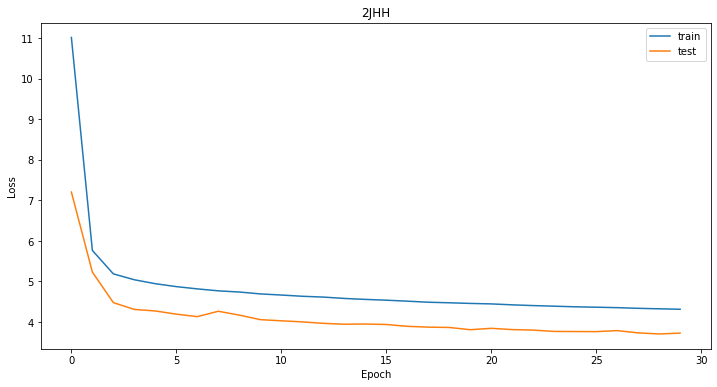

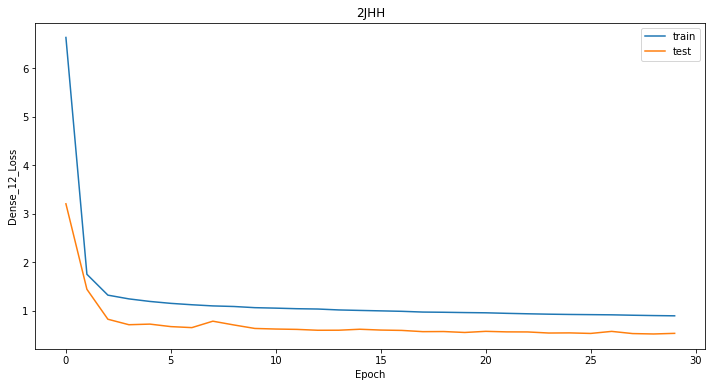

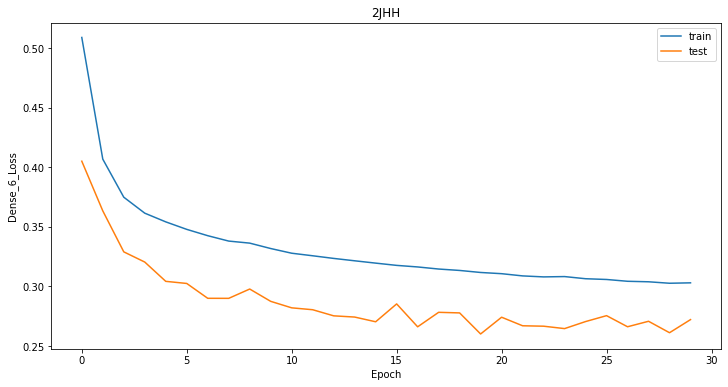

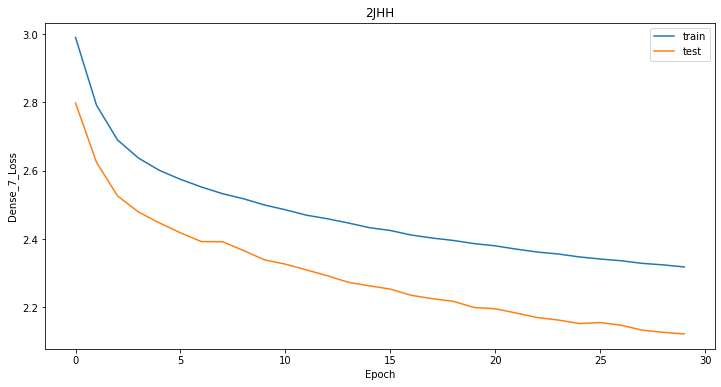

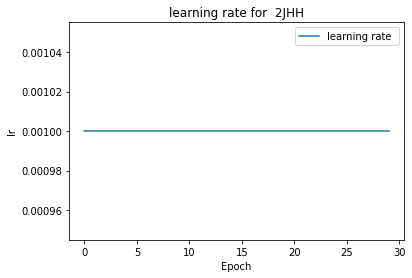

log accuracy----> -0.62885135






 12%|█▎        | 1/8 [03:25<23:58, 205.52s/it]

Training 1JHN out of ['2JHH' '1JHN' '1JHC' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 39277 samples, validate on 4365 samples
Epoch 1/30
39277/39277 [==============================] - 3s 77us/sample - loss: 50.5810 - dense_12_loss: 46.7516 - dense_6_loss: 0.9202 - dense_7_loss: 1.8637 - dense_8_loss: 1.0072 - val_loss: 51.8129 - val_dense_12_loss: 48.9438 - val_dense_6_loss: 0.8145 - val_dense_7_loss: 1.5324 - val_dense_8_loss: 0.6562
Epoch 2/30
39277/39277 [==============================] - 1s 23us/sample - loss: 48.5669 - dense_12_loss: 45.5819 - dense_6_loss: 0.6447 - dense_7_loss: 1.5673 - dense_8_loss: 0.7533 - val_loss: 50.9263 - val_dense_12_loss: 48.2385 - val_dense_6_loss: 0.5928 - val_dense_7_loss: 1.4260 - val_dense_8_loss: 0.6139
Epoch 3/30
39277/39277 [==============================] - 1s 26us/sample - loss: 47.2476 - dense_12_loss: 44.4640 - dense_6_loss: 0.5648 - dense_7_loss: 1.4541 - dense_8_loss: 0.6911 - val_loss: 47.7545 - val_dense_12_loss: 45.2730 - val_dense_

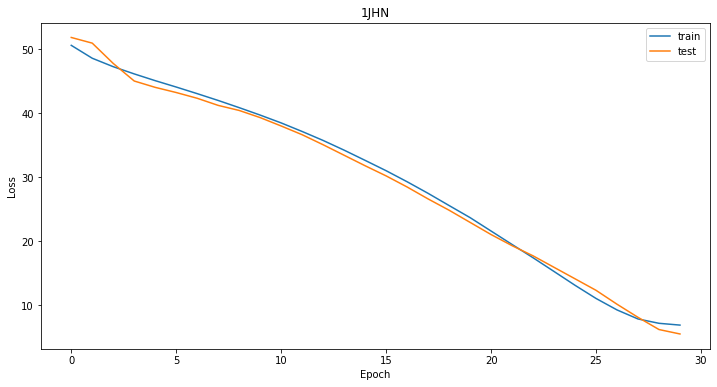

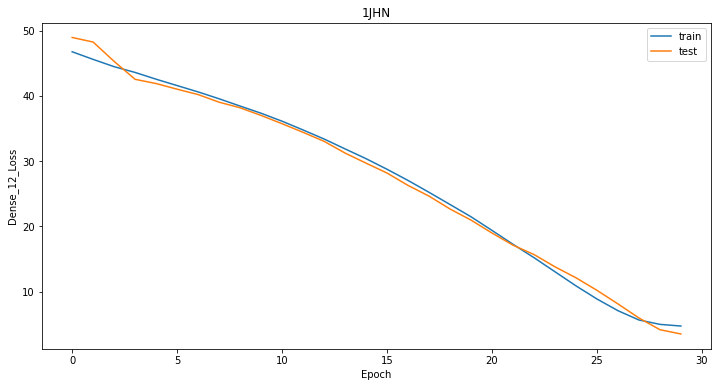

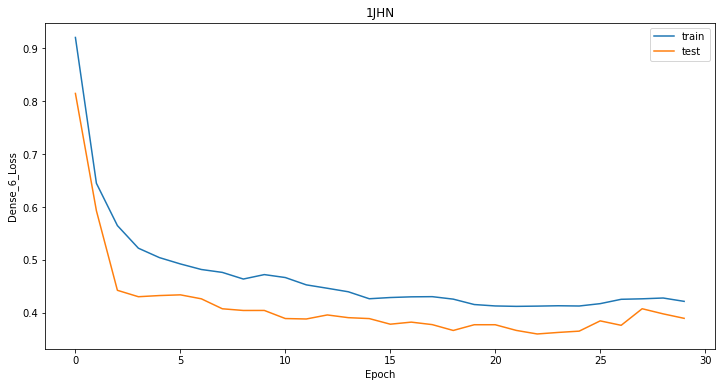

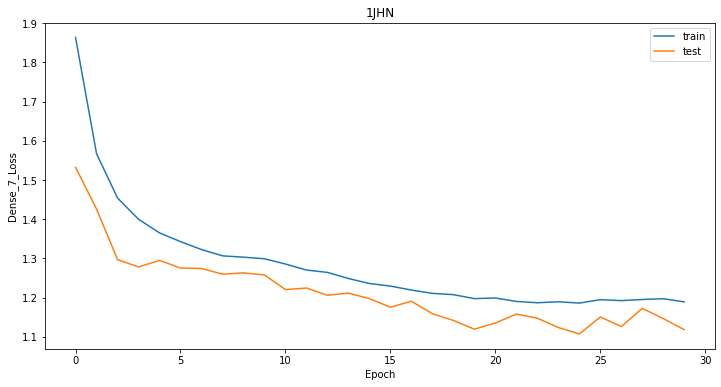

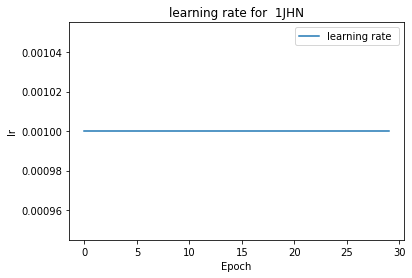

log accuracy----> 1.2280688






 25%|██▌       | 2/8 [04:07<15:39, 156.57s/it]

Training 1JHC out of ['2JHH' '1JHN' '1JHC' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 638119 samples, validate on 70903 samples
Epoch 1/30
638119/638119 [==============================] - 13s 20us/sample - loss: 90.2698 - dense_12_loss: 86.7726 - dense_6_loss: 0.5792 - dense_7_loss: 2.1425 - dense_8_loss: 0.7637 - val_loss: 80.7872 - val_dense_12_loss: 77.7026 - val_dense_6_loss: 0.4540 - val_dense_7_loss: 1.9156 - val_dense_8_loss: 0.7117
Epoch 2/30
638119/638119 [==============================] - 11s 18us/sample - loss: 62.3063 - dense_12_loss: 59.0248 - dense_6_loss: 0.5144 - dense_7_loss: 2.0182 - dense_8_loss: 0.7150 - val_loss: 46.8562 - val_dense_12_loss: 43.4941 - val_dense_6_loss: 0.5426 - val_dense_7_loss: 2.0978 - val_dense_8_loss: 0.7118
Epoch 3/30
638119/638119 [==============================] - 11s 18us/sample - loss: 17.7960 - dense_12_loss: 14.4662 - dense_6_loss: 0.5410 - dense_7_loss: 2.0672 - dense_8_loss: 0.7131 - val_loss: 8.0881 - val_dense_12_loss: 4.9203 - v

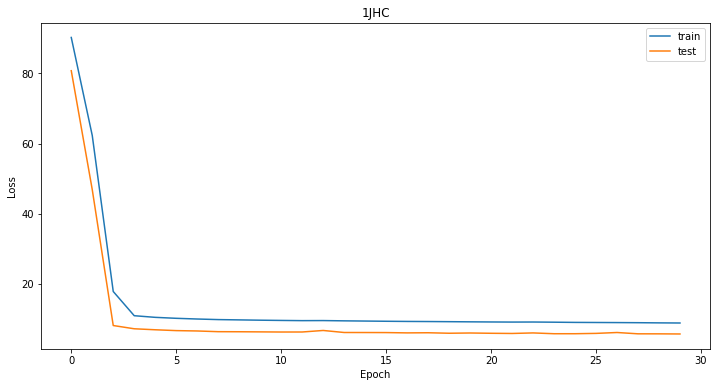

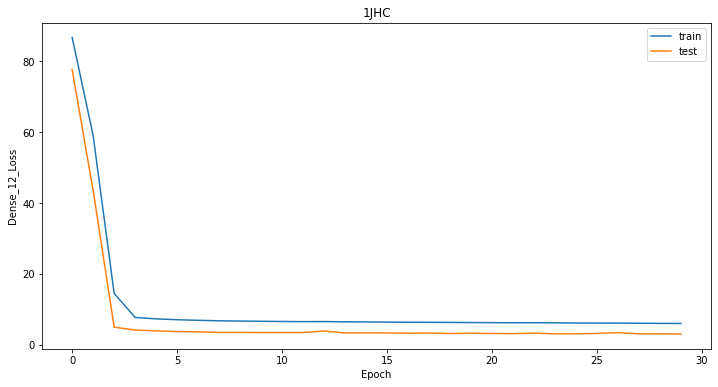

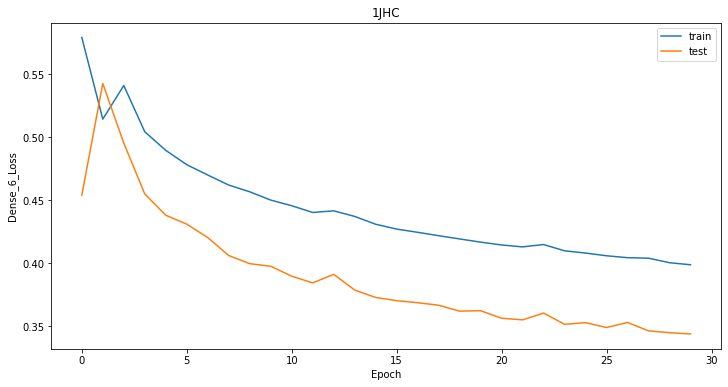

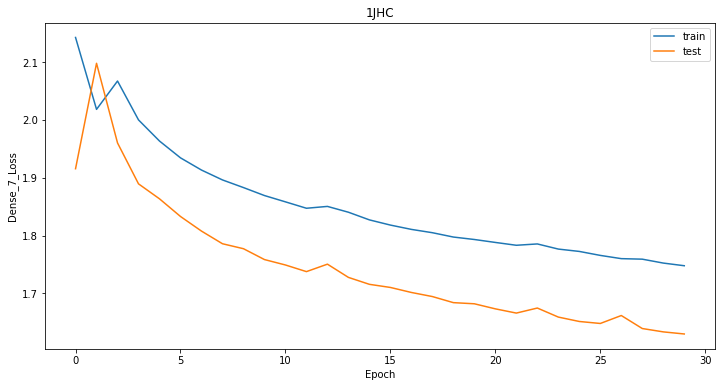

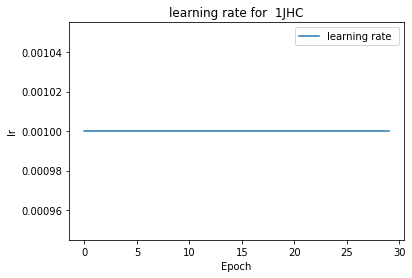

log accuracy----> 1.0963111






 38%|███▊      | 3/8 [10:36<18:50, 226.07s/it]

Training 2JHN out of ['2JHH' '1JHN' '1JHC' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 107150 samples, validate on 11906 samples
Epoch 1/30
107150/107150 [==============================] - 4s 36us/sample - loss: 5.3901 - dense_12_loss: 2.3454 - dense_6_loss: 0.6993 - dense_7_loss: 1.6696 - dense_8_loss: 0.6577 - val_loss: 5.2875 - val_dense_12_loss: 2.9280 - val_dense_6_loss: 0.5132 - val_dense_7_loss: 1.4254 - val_dense_8_loss: 0.4192
Epoch 2/30
107150/107150 [==============================] - 2s 20us/sample - loss: 3.8447 - dense_12_loss: 1.3978 - dense_6_loss: 0.5225 - dense_7_loss: 1.4449 - dense_8_loss: 0.4768 - val_loss: 3.9830 - val_dense_12_loss: 1.7792 - val_dense_6_loss: 0.4554 - val_dense_7_loss: 1.3537 - val_dense_8_loss: 0.3950
Epoch 3/30
107150/107150 [==============================] - 2s 20us/sample - loss: 3.5181 - dense_12_loss: 1.2143 - dense_6_loss: 0.4870 - dense_7_loss: 1.3704 - dense_8_loss: 0.4456 - val_loss: 3.5246 - val_dense_12_loss: 1.4140 - val_dense_6_lo

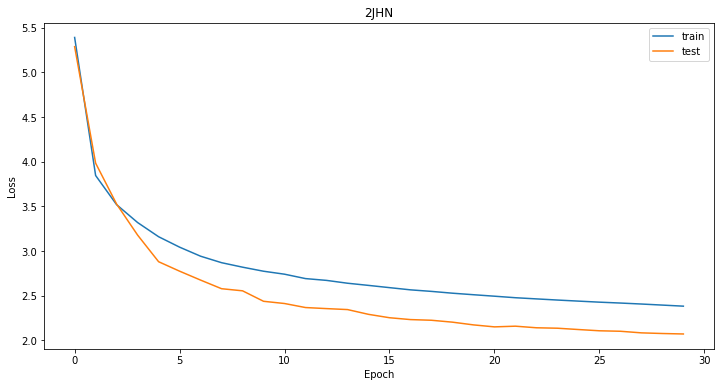

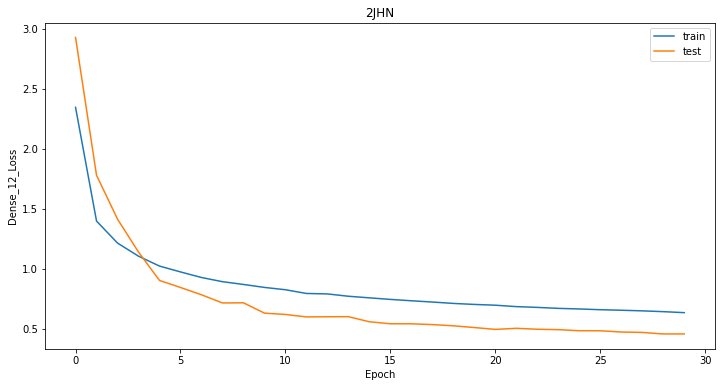

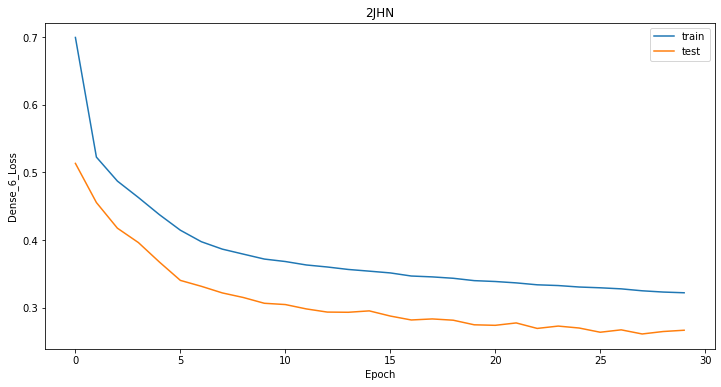

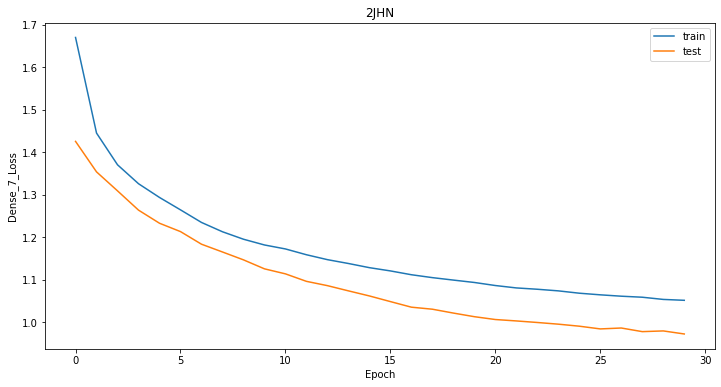

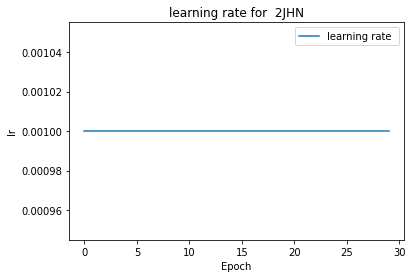

log accuracy----> -0.78339887






 50%|█████     | 4/8 [11:57<12:10, 182.57s/it]

Training 2JHC out of ['2JHH' '1JHN' '1JHC' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 1026715 samples, validate on 114080 samples
Epoch 1/30
1026715/1026715 [==============================] - 20s 20us/sample - loss: 4.6306 - dense_12_loss: 1.9963 - dense_6_loss: 0.4358 - dense_7_loss: 1.4679 - dense_8_loss: 0.7300 - val_loss: 4.0051 - val_dense_12_loss: 1.7043 - val_dense_6_loss: 0.3093 - val_dense_7_loss: 1.2973 - val_dense_8_loss: 0.6941
Epoch 2/30
1026715/1026715 [==============================] - 19s 18us/sample - loss: 4.0522 - dense_12_loss: 1.6858 - dense_6_loss: 0.3498 - dense_7_loss: 1.3226 - dense_8_loss: 0.6937 - val_loss: 3.7317 - val_dense_12_loss: 1.5014 - val_dense_6_loss: 0.2907 - val_dense_7_loss: 1.2455 - val_dense_8_loss: 0.6939
Epoch 3/30
1026715/1026715 [==============================] - 18s 18us/sample - loss: 3.7867 - dense_12_loss: 1.4800 - dense_6_loss: 0.3335 - dense_7_loss: 1.2795 - dense_8_loss: 0.6934 - val_loss: 3.4111 - val_dense_12_loss: 1.2549 - val

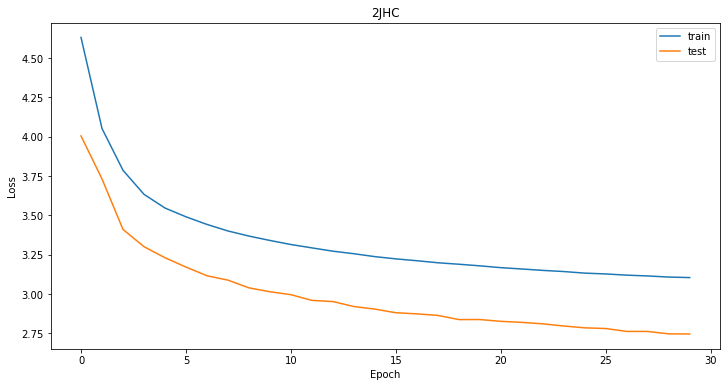

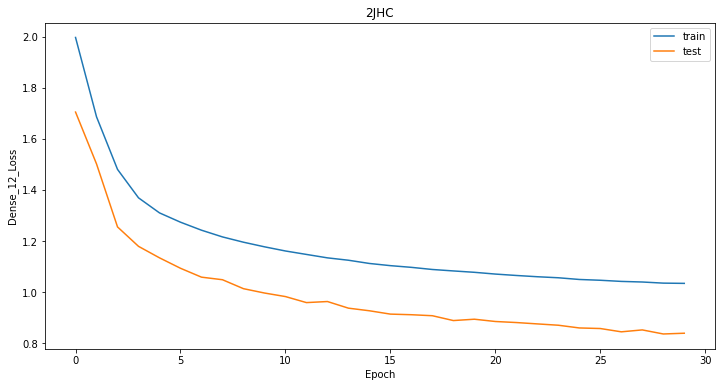

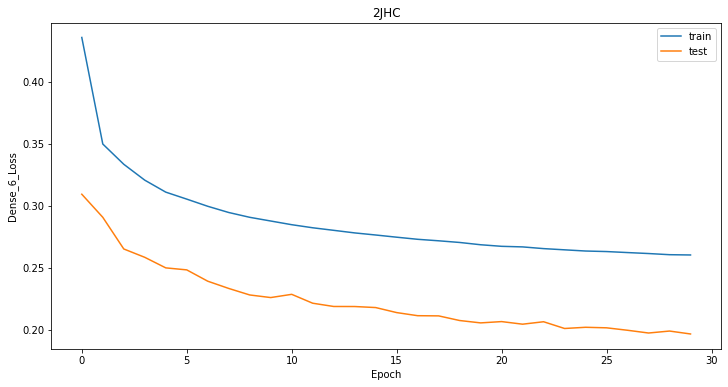

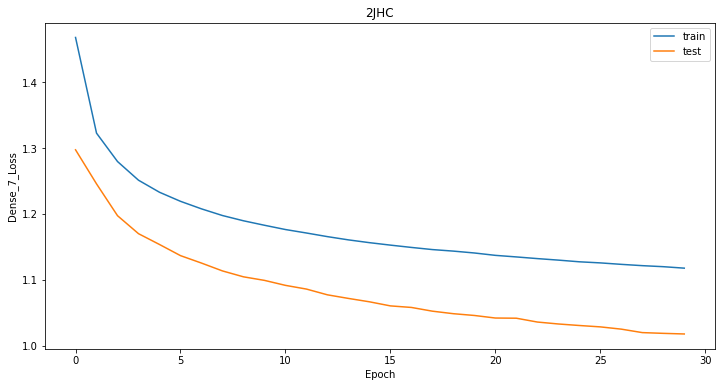

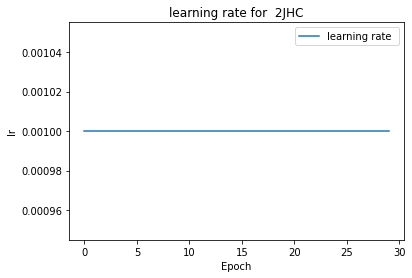

log accuracy----> -0.17564747






 62%|██████▎   | 5/8 [22:33<15:55, 318.62s/it]

Training 3JHH out of ['2JHH' '1JHN' '1JHC' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 531468 samples, validate on 59052 samples
Epoch 1/30
531468/531468 [==============================] - 12s 22us/sample - loss: 6.3571 - dense_12_loss: 2.1005 - dense_6_loss: 0.5091 - dense_7_loss: 2.9267 - dense_8_loss: 0.8187 - val_loss: 5.1062 - val_dense_12_loss: 1.2082 - val_dense_6_loss: 0.3929 - val_dense_7_loss: 2.7520 - val_dense_8_loss: 0.7532
Epoch 2/30
531468/531468 [==============================] - 10s 18us/sample - loss: 5.1665 - dense_12_loss: 1.2214 - dense_6_loss: 0.4132 - dense_7_loss: 2.7742 - dense_8_loss: 0.7575 - val_loss: 4.7157 - val_dense_12_loss: 0.9604 - val_dense_6_loss: 0.3626 - val_dense_7_loss: 2.6402 - val_dense_8_loss: 0.7525
Epoch 3/30
531468/531468 [==============================] - 10s 18us/sample - loss: 4.9512 - dense_12_loss: 1.1210 - dense_6_loss: 0.3824 - dense_7_loss: 2.6950 - dense_8_loss: 0.7527 - val_loss: 4.5227 - val_dense_12_loss: 0.9174 - val_dense_6

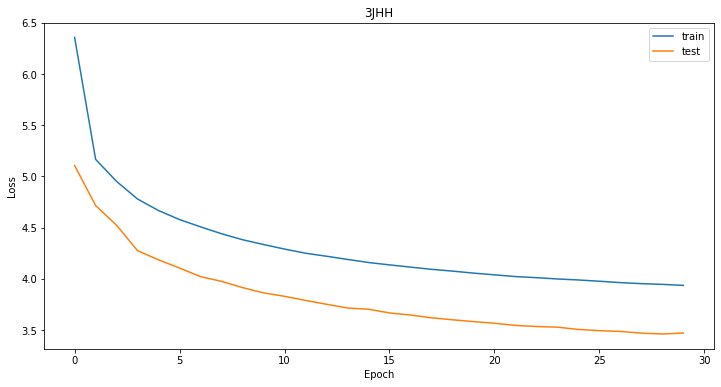

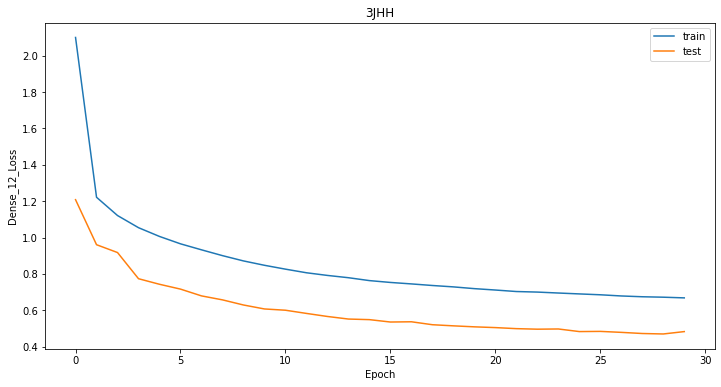

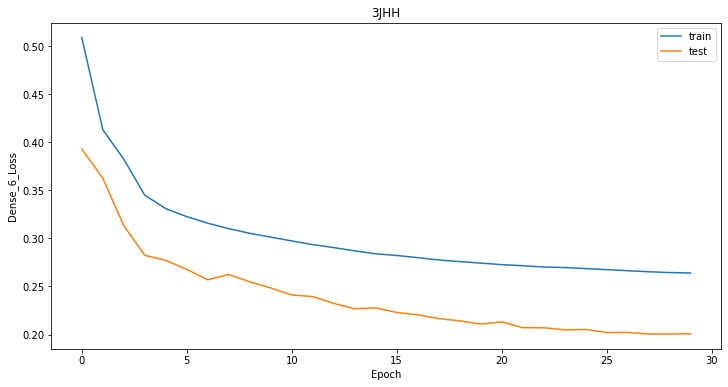

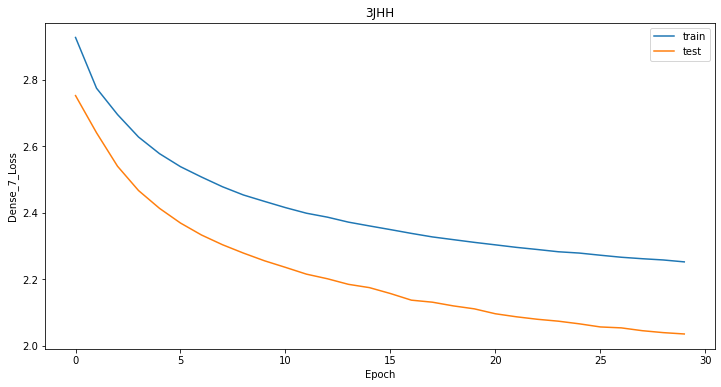

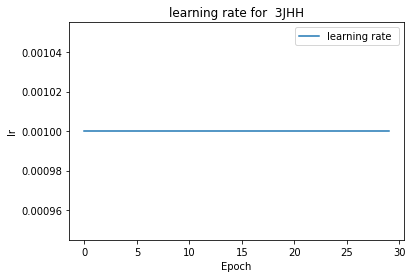

log accuracy----> -0.7288933






 75%|███████▌  | 6/8 [28:11<10:49, 324.62s/it]

Training 3JHC out of ['2JHH' '1JHN' '1JHC' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 1360030 samples, validate on 151115 samples
Epoch 1/30
1360030/1360030 [==============================] - 26s 19us/sample - loss: 4.4927 - dense_12_loss: 1.8186 - dense_6_loss: 0.4817 - dense_7_loss: 1.4685 - dense_8_loss: 0.7235 - val_loss: 3.8000 - val_dense_12_loss: 1.4087 - val_dense_6_loss: 0.3762 - val_dense_7_loss: 1.3202 - val_dense_8_loss: 0.6948
Epoch 2/30
1360030/1360030 [==============================] - 24s 18us/sample - loss: 3.8842 - dense_12_loss: 1.4477 - dense_6_loss: 0.3980 - dense_7_loss: 1.3432 - dense_8_loss: 0.6951 - val_loss: 3.5156 - val_dense_12_loss: 1.2494 - val_dense_6_loss: 0.3113 - val_dense_7_loss: 1.2601 - val_dense_8_loss: 0.6949
Epoch 3/30
1360030/1360030 [==============================] - 24s 18us/sample - loss: 3.6862 - dense_12_loss: 1.3239 - dense_6_loss: 0.3628 - dense_7_loss: 1.3044 - dense_8_loss: 0.6951 - val_loss: 3.3131 - val_dense_12_loss: 1.0989 - val

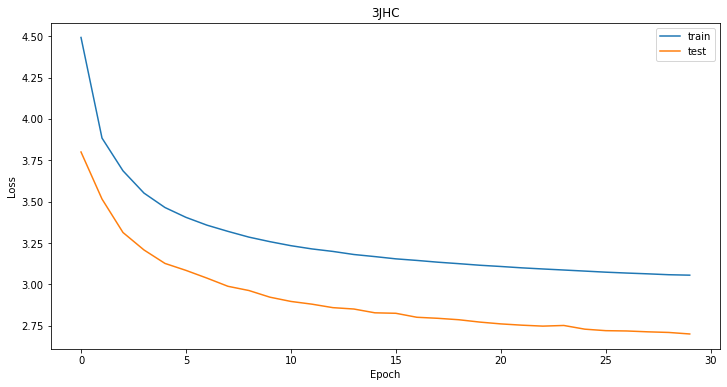

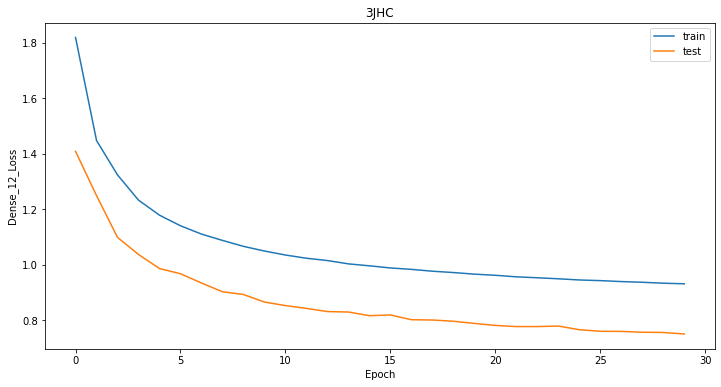

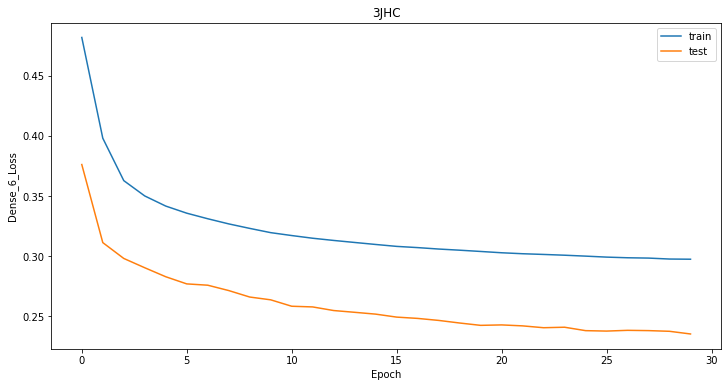

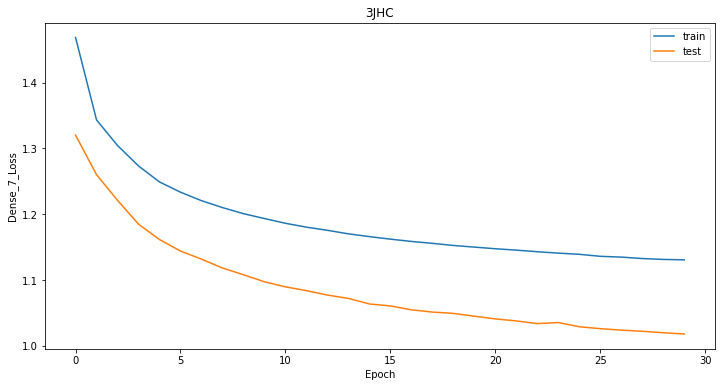

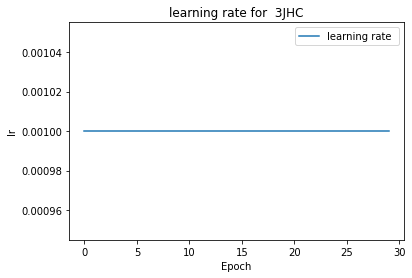

log accuracy----> -0.2857033






 88%|████████▊ | 7/8 [42:16<08:00, 480.54s/it]

Training 3JHN out of ['2JHH' '1JHN' '1JHC' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 149938 samples, validate on 16660 samples
Epoch 1/30
149938/149938 [==============================] - 5s 33us/sample - loss: 3.9745 - dense_12_loss: 1.0135 - dense_6_loss: 0.6971 - dense_7_loss: 1.6956 - dense_8_loss: 0.5645 - val_loss: 3.5707 - val_dense_12_loss: 1.0917 - val_dense_6_loss: 0.5440 - val_dense_7_loss: 1.5284 - val_dense_8_loss: 0.3945
Epoch 2/30
149938/149938 [==============================] - 3s 20us/sample - loss: 3.2772 - dense_12_loss: 0.7947 - dense_6_loss: 0.5307 - dense_7_loss: 1.5022 - dense_8_loss: 0.4481 - val_loss: 2.9363 - val_dense_12_loss: 0.7270 - val_dense_6_loss: 0.4338 - val_dense_7_loss: 1.3783 - val_dense_8_loss: 0.3852
Epoch 3/30
149938/149938 [==============================] - 3s 20us/sample - loss: 3.0186 - dense_12_loss: 0.7180 - dense_6_loss: 0.4675 - dense_7_loss: 1.4168 - dense_8_loss: 0.4154 - val_loss: 2.7734 - val_dense_12_loss: 0.6922 - val_dense_6_lo

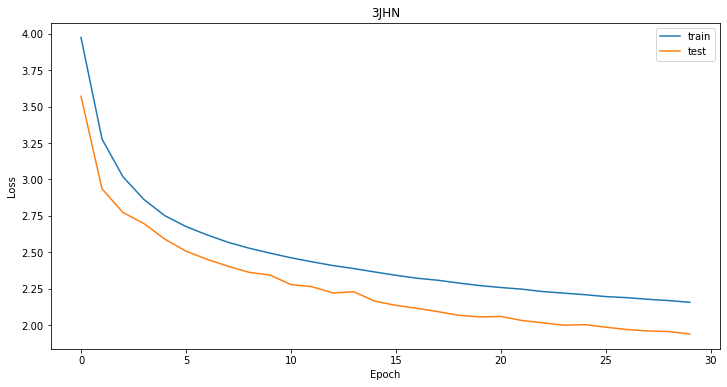

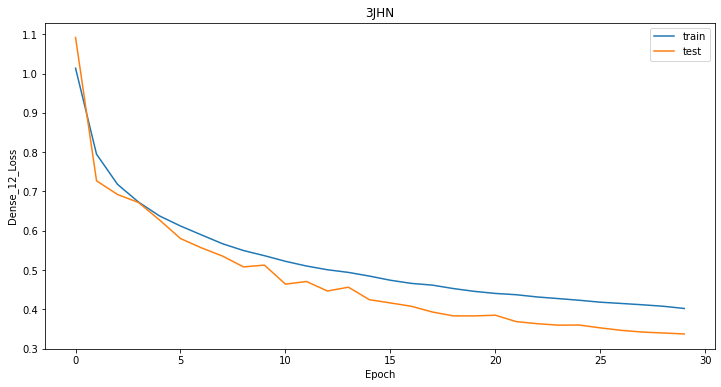

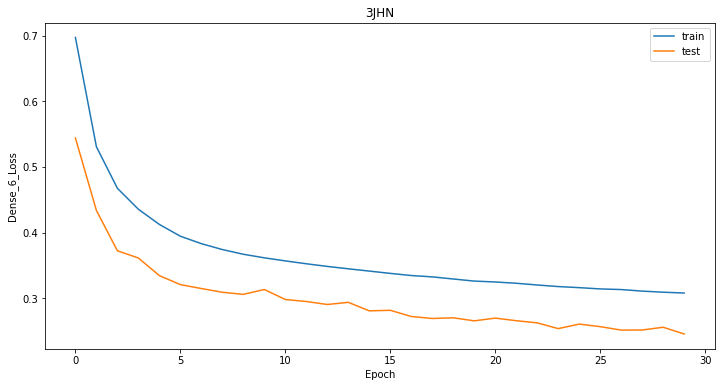

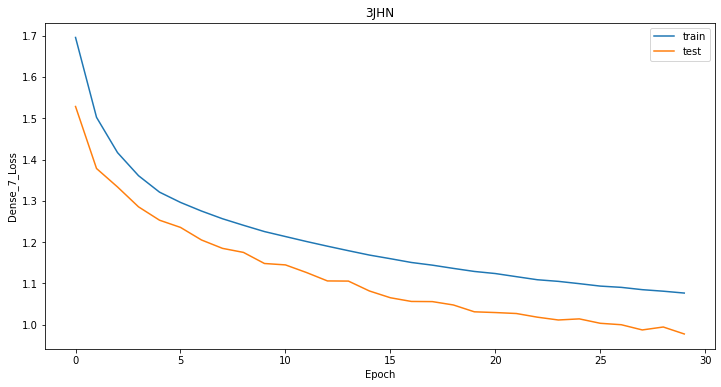

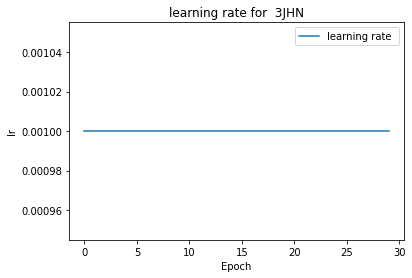

log accuracy----> -1.0821822






100%|██████████| 8/8 [44:04<00:00, 330.50s/it]


In [ ]:
cv_score_total, cv_score = train_plot_save_2(mol_types, work_dir, epoch_n=30, verbose=1, batch_size = 2048, retrain =True )

In [ ]:
cv_score_total, cv_score

(-0.17003706470131874,
 [-0.62885135,
  1.2280688,
  1.0963111,
  -0.78339887,
  -0.17564747,
  -0.7288933,
  -0.2857033,
  -1.0821822])

In [ ]:
# !rm  /content/drive/MyDrive/mole/neural_net_2xa/*

# Below there is attempt to grab all the moluecules types at once without calculating separate values annd then collecting ( also crashed first time) so I started looking for NaNs and min max values

In [ ]:
#setup for calculation
mol_types=df_train["type"].unique() #clarification of problems without JHC
# mol_types= ['1JHC', '2JHC']

epoch_n = 30 # was 300
verbose = 1 # to see on which epoch there are problems
batch_size = 2048
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True
work_dir ='/content/drive/MyDrive/mole/neural_net_2x'

In [ ]:
def train_plot_save_all( work_dir, epoch_n=30, verbose=1, batch_size = 2048, retrain =True ):

      model_name_rd = (work_dir+'/molecule_model_all.hdf5')
      model_name_wrt = (work_dir+'/molecule_model_all.hdf5')
      print('=========================>Training ... \n')
      
      # df_train_=df_train[df_train["type"]==mol_type]
      # df_test_=df_test[df_test["type"]==mol_type]
      df_train_=df_train
      df_test_=df_test
      
      # Here's our best features.  We think.
      input_features=["x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z",
                      'x_closest_0','y_closest_0','z_closest_0','x_closest_1','y_closest_1','z_closest_1',
                      "distance","distance_center0","distance_center1", "distance_c0","distance_c1","distance_f0","distance_f1",
                      "cos_c0_c1","cos_f0_f1","cos_center0_center1","cos_c0","cos_c1","cos_f0","cos_f1","cos_center0","cos_center1",
                      "atom_n"
                    ]
      
      # Standard Scaler from sklearn does seem to work better here than other Scalers
      input_data=MinMaxScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
      
      target_data=df_train_.loc[:,"scalar_coupling_constant"].values
      target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
      target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
      target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
      
      #following parameters should be adjusted to control the loss function
      #if all parameters are zero, attractors do not work. (-> simple neural network)
      m1=1
      m2=4
      m3=1
      target_data_1=m1*(MinMaxScaler().fit_transform(target_data_1))
      target_data_2=m2*(MinMaxScaler().fit_transform(target_data_2))
      target_data_3=m3*(MinMaxScaler().fit_transform(target_data_3))
      
      # Simple split to provide us a validation set to do our CV checks with
      train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
      
      # Split all our input and targets by train and cv indexes
      train_input=input_data[train_index]
      cv_input=input_data[cv_index]
      train_target=target_data[train_index]
      cv_target=target_data[cv_index]
      train_target_1=target_data_1[train_index]
      cv_target_1=target_data_1[cv_index]
      train_target_2=target_data_2[train_index]
      cv_target_2=target_data_2[cv_index]
      train_target_3=target_data_3[train_index]
      cv_target_3=target_data_3[cv_index]
      test_input=input_data[len(df_train_):,:]

      # Build the Neural Net
      nn_model=create_nn_model_1(train_input.shape[1])
      
      # If retrain==False, then we load a previous saved model as a starting point.
      if not retrain:
          nn_model = load_model(model_name_rd)
          
      nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
      
      # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
      es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=8,verbose=1, mode='auto', restore_best_weights=True)
      # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
      rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=7, min_lr=1e-6, mode='auto', verbose=1)
      # Save the best value of the model for future use
      sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True) # wykosilem period=1

      history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
              validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
              callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
      
      cv_predict=nn_model.predict(cv_input)
      
      # plot_history(history, mol_type) previous plot fuction
      # print('\n =============== Plots for dense Layers for {}'.format(mol_type))
      
      # plot_all_2(history, mol_type)
      plot_history(history, label)
      
      accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
      # cv_score.append(np.log(accuracy))
      cv_score_total=np.log(accuracy)
      print('\n Score   ', cv_score_total)
      # Predict on the test data set using our trained model
      test_predict=nn_model.predict(test_input)
      
      # for each molecule type we'll grab the predicted values
      # test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
      # K.clear_session() #was
      tf.compat.v1.keras.backend.clear_session() 
      return cv_score_total

=========================>Training ... 

Train on 4192889 samples, validate on 465877 samples
Epoch 1/30
4192889/4192889 [==============================] - 69s 16us/sample - loss: 5.1552 - dense_12_loss: 4.6654 - dense_6_loss: 0.0976 - dense_7_loss: 0.3197 - dense_8_loss: 0.0718 - val_loss: 2.6954 - val_dense_12_loss: 2.4141 - val_dense_6_loss: 0.0670 - val_dense_7_loss: 0.1758 - val_dense_8_loss: 0.0388
Epoch 2/30
4192889/4192889 [==============================] - 67s 16us/sample - loss: 3.1673 - dense_12_loss: 2.8225 - dense_6_loss: 0.0689 - dense_7_loss: 0.2370 - dense_8_loss: 0.0390 - val_loss: 2.2793 - val_dense_12_loss: 2.0151 - val_dense_6_loss: 0.0587 - val_dense_7_loss: 0.1667 - val_dense_8_loss: 0.0390
Epoch 3/30
4192889/4192889 [==============================] - 65s 16us/sample - loss: 2.9619 - dense_12_loss: 2.6459 - dense_6_loss: 0.0642 - dense_7_loss: 0.2130 - dense_8_loss: 0.0388 - val_loss: 3.3210 - val_dense_12_loss: 3.0617 - val_dense_6_loss: 0.0561 - val_dense_7_loss

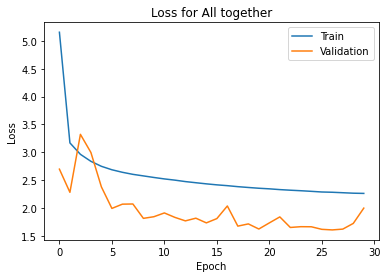

0.5709986

In [ ]:
label="All together"
train_plot_save_all( work_dir, epoch_n=30, verbose=1, batch_size = 2048, retrain =True )

and another 30 epochs

=========================>Training ... 

Train on 4192889 samples, validate on 465877 samples
Epoch 1/30
4192889/4192889 [==============================] - 69s 16us/sample - loss: 2.2734 - dense_12_loss: 2.0285 - dense_6_loss: 0.0520 - dense_7_loss: 0.1543 - dense_8_loss: 0.0386 - val_loss: 1.6288 - val_dense_12_loss: 1.4049 - val_dense_6_loss: 0.0423 - val_dense_7_loss: 0.1430 - val_dense_8_loss: 0.0385
Epoch 2/30
4192889/4192889 [==============================] - 66s 16us/sample - loss: 2.2649 - dense_12_loss: 2.0202 - dense_6_loss: 0.0519 - dense_7_loss: 0.1542 - dense_8_loss: 0.0386 - val_loss: 1.7679 - val_dense_12_loss: 1.5436 - val_dense_6_loss: 0.0428 - val_dense_7_loss: 0.1429 - val_dense_8_loss: 0.0386
Epoch 3/30
4192889/4192889 [==============================] - 65s 16us/sample - loss: 2.2558 - dense_12_loss: 2.0114 - dense_6_loss: 0.0518 - dense_7_loss: 0.1540 - dense_8_loss: 0.0386 - val_loss: 1.7005 - val_dense_12_loss: 1.4764 - val_dense_6_loss: 0.0426 - val_dense_7_loss

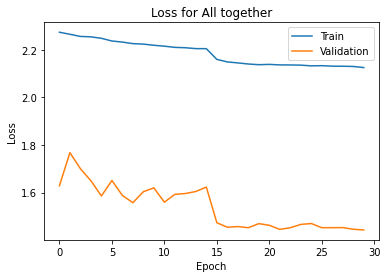

0.20403504

In [ ]:
cv_score_total = train_plot_save_all( work_dir, epoch_n=30, verbose=1, batch_size = 2048, retrain =False )
cv_score_total